In [8]:
S3_location = "s3://ai2-llm/pretraining-data/sources/stack-dedup/v0/attributes/file_stats"
URLS_LIST = "../create/stack_dedup_v1.1_urls.txt"

In [3]:
import pandas as pd
import os

In [6]:
path = os.path.join(S3_location, "python", "data_0000.tsv")
df = pd.read_csv(path, sep="\t")

In [19]:
lang_urls = {}
with open(URLS_LIST) as f:
    lines = f.readlines()
    for line in lines:
        url = "/".join(line.split("/")[-2:]).strip().replace(".parquet", ".tsv")
        lang = url.split("/")[0]
        if lang in lang_urls:
            lang_urls[lang].append(url)
        else:
            lang_urls[lang] = [url]

In [23]:
lang = "abap"

all_dfs = []
for url in lang_urls[lang]:
    path = os.path.join(S3_location, url)
    df = pd.read_csv(path, sep="\t")
    all_dfs.append(df)

df = pd.concat(all_dfs)

In [27]:
df.to_csv("merged_abap.tsv", sep="\t")

In [25]:
df["line_count"].sum()

2924937

In [30]:
import json

In [32]:
with open("lang_files.json", "w") as f:
    json.dump(lang_urls, f)

In [33]:
with open("lang_files.json") as f:
    lf = json.load(f)

### 29 April 2023

In [3]:
MERGED_STATS = "../analyze/merged"

In [6]:
import pandas as pd
import os

In [7]:
lang = "python"
path = os.path.join(MERGED_STATS, f"merged_{lang}_stats.tsv")


In [11]:
df = df.drop(columns=["Unnamed: 0"])

In [25]:
df

,id,max_line_length,avg_line_length,num_characters,line_count,num_tokens_whitespace,alnum_prop
0,900000adc880b3f11205aecc535df29d629a6d0c,135,29.861111,3225,108,275,0.572093
1,90000123c3c98721346f41595fd534d124b2f830,69,21.275862,617,29,54,0.555916
2,9000014700819c031686be68800c6f771efb2695,124,41.670902,32795,787,2175,0.551517
3,90000324dfde4b624d3ad0979d89a438d0443b5c,119,49.500000,5544,112,411,0.619228
4,9000053b61a61a1ac2159e9bc1406f2b350532b6,79,35.037736,1857,53,272,0.653743
...,...,...,...,...,...,...,...
15148599,7cfffbeef703aae9a0eddf585ae768c178b3cf66,76,31.772727,699,22,53,0.666667
15148600,7cfffe678d106e7dbd5cd14e6764d27402d0a789,145,40.875000,2289,56,194,0.587156
15148601,7cfffeb814bc4b9668233c97fe82267404f3cd4c,83,35.000000,4235,121,329,0.604014
15148602,7cffff37b2d5bf8236ee0aa7d33d0bf05bac5452,1992,51.475728,5302,103,516,0.562052


In [23]:
filtered_df = df[(df["max_line_length"] > 1000) | (df["avg_line_length"] > 100) | (df["alnum_prop"] < 0.25)]

In [24]:
len(df) - len(filtered_df)

15036358

In [26]:
df["num_tokens_whitespace"].sum() - filtered_df["num_tokens_whitespace"].sum()

6446572637

In [27]:
import re

In [28]:
# Regex to strip repeated copyright comment blocks
CPAT = re.compile("copyright", re.IGNORECASE)
PAT = re.compile("/\\*[^*]*\\*+(?:[^/*][^*]*\\*+)*/")


def clean_copyright_comments(content: str):
    r = PAT.search(content)
    if r:
        # found one, now see if it contains "copyright", if so strip it
        span = r.span()
        sub = content[span[0] : span[1]]
        if CPAT.search(sub):
            # cut it
            content = content[: span[0]] + content[span[1] :]

        return content

    lines = content.split("\n")
    skip = 0

    # Greedy replace any file that begins with comment block, most
    # are copyright headers
    for k in range(len(lines)):
        if lines[k].startswith("//") or lines[k].startswith("#") or lines[k].startswith("--") or not lines[k]:
            skip = skip + 1
        else:
            break

    if skip:
        # we skipped, consume it
        content = "\n".join(lines[skip:])

    return content

In [29]:
S3_location = "s3://ai2-llm/pretraining-data/sources/stack-dedup/v0/documents"

In [92]:
path = os.path.join(S3_location, "python", "data_0000.jsonl.gz")
df = pd.read_json(path, lines=True, compression="gzip")

In [93]:
df["new_text"] = df["text"].apply(clean_copyright_comments)

In [94]:
df.to_json?

In [33]:
df[df["text"] != df["new_text"]]

,id,lang,text,metadata,timestamp,source,added,new_text
4,9000053b61a61a1ac2159e9bc1406f2b350532b6,python,# This code is based on the SOM class library....,"{'size': 1857, 'ext': 'py', 'max_stars_repo_pa...",2022-12-01,stack-dedup,2023-03-17T09:18:30.577245,from benchmark import Benchmark\n\n\nclass Per...
7,9000070b2550faa1d17f57c00a6b8e20ec634906,python,# Built in python libs\nimport os\nimport time...,"{'size': 8214, 'ext': 'py', 'max_stars_repo_pa...",2022-12-01,stack-dedup,2023-03-17T09:18:30.577245,import os\nimport time\n\n# Additional libs\ni...
8,9000085392939d04983239353323c8e90fdb8c0e,python,#!/usr/bin/env python3\n# Copyright 2013 The F...,"{'size': 1212, 'ext': 'py', 'max_stars_repo_pa...",2022-12-01,stack-dedup,2023-03-17T09:18:30.577245,import argparse\nfrom fontTools import ttLib\n...
9,900008ef07bdbed94ca34c73bf749d14b9bceef0,python,# coding=utf-8\nimport json\nimport pandas as ...,"{'size': 5011, 'ext': 'py', 'max_stars_repo_pa...",2022-12-01,stack-dedup,2023-03-17T09:18:30.577245,import json\nimport pandas as pd\nimport reque...
13,90000b542dae43e88da510338901abd49ec24789,python,#!/usr/bin/env python\n# coding=utf-8\nimport ...,"{'size': 1086, 'ext': 'py', 'max_stars_repo_pa...",2022-12-01,stack-dedup,2023-03-17T09:18:30.577245,import numpy as np\nimport sys\n\nyears = sys....
...,...,...,...,...,...,...,...,...
152091,d5a39141c5e781840061ae86fd63aa6ce228d136,python,# Licensed under a 3-clause BSD style license ...,"{'size': 217, 'ext': 'py', 'max_stars_repo_pat...",2022-12-01,stack-dedup,2023-03-17T09:18:30.577245,"from __future__ import print_function, divisio..."
152093,d5a3945cc71448fdd3ffa595169892fcf3cb5488,python,# -*- coding: utf-8 -*-\n# Generated by Django...,"{'size': 735, 'ext': 'py', 'max_stars_repo_pat...",2022-12-01,stack-dedup,2023-03-17T09:18:30.577245,from __future__ import unicode_literals\n\nimp...
152094,d5a395ac1be24ebd884c61e4889ff3d31535262f,python,# -*- coding: utf-8 -*-\nfrom os import remove...,"{'size': 6386, 'ext': 'py', 'max_stars_repo_pa...",2022-12-01,stack-dedup,2023-03-17T09:18:30.577245,"from os import remove, environ\nimport logging..."
152098,d5a39d463bd373321c5c571d263bbda7325d4811,python,#!/usr/bin/env python3\n#\n# Copyright 2014 Si...,"{'size': 1980, 'ext': 'py', 'max_stars_repo_pa...",2022-12-01,stack-dedup,2023-03-17T09:18:30.577245,"__author__ = ""Simone Campagna""\n\n__all__ = [\..."


In [34]:
df

,id,lang,text,metadata,timestamp,source,added,new_text
0,900000adc880b3f11205aecc535df29d629a6d0c,python,"""""""\nbenchmarking et plotting some results for...","{'size': 3225, 'ext': 'py', 'max_stars_repo_pa...",2022-12-01,stack-dedup,2023-03-17T09:18:30.577245,"""""""\nbenchmarking et plotting some results for..."
1,90000123c3c98721346f41595fd534d124b2f830,python,temp =[]\nprinc=[]\nmaior=menor=0\n\nwhile Tru...,"{'size': 617, 'ext': 'py', 'max_stars_repo_pat...",2022-12-01,stack-dedup,2023-03-17T09:18:30.577245,temp =[]\nprinc=[]\nmaior=menor=0\n\nwhile Tru...
2,9000014700819c031686be68800c6f771efb2695,python,"""""""\nThis module implements an API for interac...","{'size': 32795, 'ext': 'py', 'max_stars_repo_p...",2022-12-01,stack-dedup,2023-03-17T09:18:30.577245,"""""""\nThis module implements an API for interac..."
3,90000324dfde4b624d3ad0979d89a438d0443b5c,python,from ._object_env import ObjectEnv\nfrom ._obj...,"{'size': 5544, 'ext': 'py', 'max_stars_repo_pa...",2022-12-01,stack-dedup,2023-03-17T09:18:30.577245,from ._object_env import ObjectEnv\nfrom ._obj...
4,9000053b61a61a1ac2159e9bc1406f2b350532b6,python,# This code is based on the SOM class library....,"{'size': 1857, 'ext': 'py', 'max_stars_repo_pa...",2022-12-01,stack-dedup,2023-03-17T09:18:30.577245,from benchmark import Benchmark\n\n\nclass Per...
...,...,...,...,...,...,...,...,...
152097,d5a39bddc227e2320abd0ac10ad3a6e499a3455a,python,from rest_framework import serializers\nfrom a...,"{'size': 221, 'ext': 'py', 'max_stars_repo_pat...",2022-12-01,stack-dedup,2023-03-17T09:18:30.577245,from rest_framework import serializers\nfrom a...
152098,d5a39d463bd373321c5c571d263bbda7325d4811,python,#!/usr/bin/env python3\n#\n# Copyright 2014 Si...,"{'size': 1980, 'ext': 'py', 'max_stars_repo_pa...",2022-12-01,stack-dedup,2023-03-17T09:18:30.577245,"__author__ = ""Simone Campagna""\n\n__all__ = [\..."
152099,d5a39e6052dec6a6ade93459410a765d7d0c49c9,python,# SPDX-License-Identifier: Apache-2.0.\nimport...,"{'size': 6355, 'ext': 'py', 'max_stars_repo_pa...",2022-12-01,stack-dedup,2023-03-17T09:18:30.577245,import logging\nfrom contextlib import closing...
152100,d5a39eb2f736ab4cd0cd0395f70d0a284bb8c52f,python,from django.core.management.base import BaseCo...,"{'size': 3686, 'ext': 'py', 'max_stars_repo_pa...",2022-12-01,stack-dedup,2023-03-17T09:18:30.577245,from django.core.management.base import BaseCo...


In [36]:
!pip install detect-secrets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 17.5 MB/s eta 0:00:00


In [48]:
from detect_secrets import SecretsCollection
from detect_secrets.settings import default_settings
from detect_secrets.core.scan import PotentialSecret, get_plugins, _process_line_based_plugins
from typing import Generator

the_str = "code_str.yml"

def scan_code(code: str) -> Generator[PotentialSecret, None, None]:
    if not get_plugins():   # pragma: no cover
        log.error('No plugins to scan with!')
        return

    has_secret = False
    for lines in [code.splitlines()]:
        for secret in _process_line_based_plugins(
            lines=list(enumerate(lines, start=1)),
            filename=the_str,
        ):
            has_secret = True
            yield secret

        if has_secret:
            break

class MySecretsCollection(SecretsCollection):
    def scan_str(self, code_str: str):
        for secret in scan_code(code_str):
            self[the_str].add(secret)

def check_for_secrets(code: str):
    secrets = MySecretsCollection()
    with default_settings():
        secrets.scan_str(code)

    secrets_json = secrets.json()
    if secrets_json:
        for secret in secrets_json[the_str]:
            print("verified", secret["is_verified"])
        return True
    return False

In [57]:
check_for_secrets('hello = "T2w5Vl9ZTUIzVzE5dTlBblUtRlo6MHNBYWxhbHVTeGFodUpUOWIybkNNZw=="')

verified False


True

In [58]:
check_for_secrets('contact = akshitab@allenai.org')

False

In [50]:
check_for_secrets("print('hello')")

False

In [53]:
df["text"].head(500).apply(check_for_secrets)

verified False
verified False
verified False
verified False
verified False
verified False
verified False
verified False
verified False
verified False
verified False
verified False
verified False
verified False
verified False
verified False
verified False
verified False
verified False
verified False
verified False
verified False
verified False
verified False
verified False
verified False
verified False
verified False
verified False
verified False
verified False
verified False
verified False
verified False


0      False
1      False
2      False
3      False
4      False
       ...  
495    False
496    False
497    False
498    False
499    False
Name: text, Length: 500, dtype: bool

In [59]:
dsets = default_settings()

In [60]:
dsets

In [45]:
print(df.iloc[39]["text"])

"""
Django settings for mysite project.

Generated by 'django-admin startproject' using Django 3.2.

For more information on this file, see
https://docs.djangoproject.com/en/3.2/topics/settings/

For the full list of settings and their values, see
https://docs.djangoproject.com/en/3.2/ref/settings/
"""

from pathlib import Path

# Build paths inside the project like this: BASE_DIR / 'subdir'.
BASE_DIR = Path(__file__).resolve().parent.parent


# Quick-start development settings - unsuitable for production
# See https://docs.djangoproject.com/en/3.2/howto/deployment/checklist/

# SECURITY WARNING: keep the secret key used in production secret!
SECRET_KEY = 'django-insecure-$su^!=k#jx24b_mg1(oi)j7vgio%9gtbb+)uv1mw420r#mp%ru'

# SECURITY WARNING: don't run with debug turned on in production!
DEBUG = True

ALLOWED_HOSTS = []


# Application definition

INSTALLED_APPS = [
    'django.contrib.admin',
    'django.contrib.auth',
    'django.contrib.contenttypes',
    'django.contrib.sessions',

In [90]:
path = os.path.join(S3_location, "jsoniq", "data_0000.jsonl.gz")
df = pd.read_json(path, lines=True, compression="gzip")

In [91]:
df["text"].values[1]

'{\n  "tag_name": "v1.7.0",\n  "name": "The Aristotle release",\n  "draft": false,\n  "prerelease": true,\n  "body": $changelog\n}'

In [1]:
df

NameError: name 'df' is not defined

### 30 April 2023

In [2]:
import pandas as pd
import os

In [7]:
S3_location = "s3://ai2-llm/pretraining-data/sources/stack-dedup/v1/attributes"
path = os.path.join(S3_location, "python", "data_0000.tsv")
df = pd.read_csv(path, sep="\t")

In [11]:
df[df["id"].isna()]

,id,alnum_prop,line_count,num_tokens_whitespace,num_alpha,alpha_count,max_line_length,avg_line_length,alnum_count,num_characters
784,NaN,0.0,0.0,0.0,0.0,NaN,0.0,0.0,NaN,0.0
1082,NaN,0.0,0.0,0.0,0.0,NaN,0.0,0.0,NaN,0.0
1252,NaN,0.0,0.0,0.0,0.0,NaN,0.0,0.0,NaN,0.0
1580,NaN,0.0,0.0,0.0,0.0,NaN,0.0,0.0,NaN,0.0
1740,NaN,0.0,0.0,0.0,0.0,NaN,0.0,0.0,NaN,0.0
...,...,...,...,...,...,...,...,...,...,...
150483,NaN,0.0,0.0,0.0,0.0,NaN,0.0,0.0,NaN,0.0
151091,NaN,0.0,0.0,0.0,0.0,NaN,0.0,0.0,NaN,0.0
151473,NaN,0.0,0.0,0.0,0.0,NaN,0.0,0.0,NaN,0.0
151594,NaN,0.0,0.0,0.0,0.0,NaN,0.0,0.0,NaN,0.0


In [15]:
df[df["num_tokens_whitespace"] < 50]

,id,alnum_prop,line_count,num_tokens_whitespace,num_alpha,alpha_count,max_line_length,avg_line_length,alnum_count,num_characters
5,9000066e02e8dd2095aa95d6ac7ca85ad4c9e016,0.800000,1.0,4.0,NaN,20.0,24.0,25.000000,20.0,25.0
8,9000085392939d04983239353323c8e90fdb8c0e,0.694737,17.0,46.0,NaN,330.0,61.0,27.941176,330.0,475.0
10,90000a1b36aa3c75157aac2116dd2271317d6683,0.763006,8.0,12.0,NaN,132.0,82.0,21.625000,132.0,173.0
18,900013ccc8655d877d6553a8120f47a07a5f8cba,0.468992,14.0,42.0,NaN,112.0,31.0,18.428571,121.0,258.0
22,90001690169c6ec7744d2037ad6d3c145ce3a539,0.725552,14.0,27.0,NaN,220.0,44.0,22.642857,230.0,317.0
...,...,...,...,...,...,...,...,...,...,...
152088,d5a38f0dacc713ae708435c74429561e89ad8b0b,0.622378,7.0,23.0,NaN,89.0,51.0,20.428571,89.0,143.0
152091,d5a39141c5e781840061ae86fd63aa6ce228d136,0.692810,7.0,18.0,NaN,106.0,47.0,21.857143,106.0,153.0
152093,d5a3945cc71448fdd3ffa595169892fcf3cb5488,0.590634,26.0,45.0,NaN,368.0,107.0,25.461538,391.0,662.0
152096,d5a39b1a95d588c6e471fa3b22cdd5d0c2d956c7,0.441860,25.0,47.0,NaN,182.0,36.0,17.200000,190.0,430.0


In [14]:
df

,id,alnum_prop,line_count,num_tokens_whitespace,num_alpha,alpha_count,max_line_length,avg_line_length,alnum_count,num_characters
0,900000adc880b3f11205aecc535df29d629a6d0c,0.572093,108.0,275.0,NaN,1759.0,135.0,29.861111,1845.0,3225.0
1,90000123c3c98721346f41595fd534d124b2f830,0.555916,29.0,54.0,NaN,333.0,69.0,21.275862,343.0,617.0
2,9000014700819c031686be68800c6f771efb2695,0.551517,787.0,2175.0,NaN,17876.0,124.0,41.670902,18087.0,32795.0
3,90000324dfde4b624d3ad0979d89a438d0443b5c,0.619228,112.0,411.0,NaN,3364.0,119.0,49.500000,3433.0,5544.0
4,9000053b61a61a1ac2159e9bc1406f2b350532b6,0.452482,32.0,74.0,NaN,299.0,39.0,22.031250,319.0,705.0
...,...,...,...,...,...,...,...,...,...,...
152097,d5a39bddc227e2320abd0ac10ad3a6e499a3455a,0.746606,9.0,18.0,NaN,165.0,62.0,24.555556,165.0,221.0
152098,d5a39d463bd373321c5c571d263bbda7325d4811,0.736344,49.0,146.0,NaN,1009.0,81.0,28.020408,1011.0,1373.0
152099,d5a39e6052dec6a6ade93459410a765d7d0c49c9,0.561273,188.0,465.0,NaN,3534.0,91.0,33.595745,3545.0,6316.0
152100,d5a39eb2f736ab4cd0cd0395f70d0a284bb8c52f,0.554259,95.0,225.0,NaN,2016.0,84.0,38.800000,2043.0,3686.0


In [16]:
S3_location = "s3://ai2-llm/pretraining-data/sources/stack-dedup/v1/documents"
path = os.path.join(S3_location, "python", "data_0000.jsonl.gz")
dfx = pd.read_json(path, lines=True, compression="gzip")

In [20]:
fdf = pd.merge(df, dfx, on="id")

In [64]:
def filter_by_filecontent_stats(instance_attributes) -> bool:

    if instance_attributes["max_line_length"] > 1000:
        return False

    if instance_attributes["avg_line_length"] > 100:
        return False

    if instance_attributes["alnum_prop"] < 0.25:
        return False

    if instance_attributes["num_tokens_whitespace"] < 50:
        return False

    if instance_attributes["alpha_count"] / instance_attributes["num_tokens_whitespace"] < 1.5:
        return False

    return True

In [65]:
fdf

,id,alnum_prop,line_count,num_tokens_whitespace,num_alpha,alpha_count,max_line_length,avg_line_length,alnum_count,num_characters,lang,text,metadata,timestamp,source,added
0,900000adc880b3f11205aecc535df29d629a6d0c,0.572093,108.0,275.0,NaN,1759.0,135.0,29.861111,1845.0,3225.0,python,"""""""\nbenchmarking et plotting some results for...","{'size': 3225, 'ext': 'py', 'max_stars_repo_pa...",2022-12-01,stack-dedup,2023-03-17T09:18:30.577245
1,90000123c3c98721346f41595fd534d124b2f830,0.555916,29.0,54.0,NaN,333.0,69.0,21.275862,343.0,617.0,python,temp =[]\nprinc=[]\nmaior=menor=0\n\nwhile Tru...,"{'size': 617, 'ext': 'py', 'max_stars_repo_pat...",2022-12-01,stack-dedup,2023-03-17T09:18:30.577245
2,9000014700819c031686be68800c6f771efb2695,0.551517,787.0,2175.0,NaN,17876.0,124.0,41.670902,18087.0,32795.0,python,"""""""\nThis module implements an API for interac...","{'size': 32795, 'ext': 'py', 'max_stars_repo_p...",2022-12-01,stack-dedup,2023-03-17T09:18:30.577245
3,90000324dfde4b624d3ad0979d89a438d0443b5c,0.619228,112.0,411.0,NaN,3364.0,119.0,49.500000,3433.0,5544.0,python,from ._object_env import ObjectEnv\nfrom ._obj...,"{'size': 5544, 'ext': 'py', 'max_stars_repo_pa...",2022-12-01,stack-dedup,2023-03-17T09:18:30.577245
4,9000053b61a61a1ac2159e9bc1406f2b350532b6,0.452482,32.0,74.0,NaN,299.0,39.0,22.031250,319.0,705.0,python,from benchmark import Benchmark\n\n\nclass Per...,"{'size': 1857, 'ext': 'py', 'max_stars_repo_pa...",2022-12-01,stack-dedup,2023-03-17T09:18:30.577245
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
151695,d5a39bddc227e2320abd0ac10ad3a6e499a3455a,0.746606,9.0,18.0,NaN,165.0,62.0,24.555556,165.0,221.0,python,from rest_framework import serializers\nfrom a...,"{'size': 221, 'ext': 'py', 'max_stars_repo_pat...",2022-12-01,stack-dedup,2023-03-17T09:18:30.577245
151696,d5a39d463bd373321c5c571d263bbda7325d4811,0.736344,49.0,146.0,NaN,1009.0,81.0,28.020408,1011.0,1373.0,python,"__author__ = ""Simone Campagna""\n\n__all__ = [\...","{'size': 1980, 'ext': 'py', 'max_stars_repo_pa...",2022-12-01,stack-dedup,2023-03-17T09:18:30.577245
151697,d5a39e6052dec6a6ade93459410a765d7d0c49c9,0.561273,188.0,465.0,NaN,3534.0,91.0,33.595745,3545.0,6316.0,python,import logging\nfrom contextlib import closing...,"{'size': 6355, 'ext': 'py', 'max_stars_repo_pa...",2022-12-01,stack-dedup,2023-03-17T09:18:30.577245
151698,d5a39eb2f736ab4cd0cd0395f70d0a284bb8c52f,0.554259,95.0,225.0,NaN,2016.0,84.0,38.800000,2043.0,3686.0,python,from django.core.management.base import BaseCo...,"{'size': 3686, 'ext': 'py', 'max_stars_repo_pa...",2022-12-01,stack-dedup,2023-03-17T09:18:30.577245


In [72]:
fdf = fdf[fdf.apply(filter_by_filecontent_stats, axis=1)]

In [67]:
len(fdf), len(df)

(151700, 152102)

In [69]:
len(dfx)

152102

In [70]:
df.columns

Index(['id', 'alnum_prop', 'line_count', 'num_tokens_whitespace', 'num_alpha',
       'alpha_count', 'max_line_length', 'avg_line_length', 'alnum_count',
       'num_characters'],
      dtype='object')

In [74]:
fdf[dfx.columns]

,id,lang,text,metadata,timestamp,source,added
0,900000adc880b3f11205aecc535df29d629a6d0c,python,"""""""\nbenchmarking et plotting some results for...","{'size': 3225, 'ext': 'py', 'max_stars_repo_pa...",2022-12-01,stack-dedup,2023-03-17T09:18:30.577245
1,90000123c3c98721346f41595fd534d124b2f830,python,temp =[]\nprinc=[]\nmaior=menor=0\n\nwhile Tru...,"{'size': 617, 'ext': 'py', 'max_stars_repo_pat...",2022-12-01,stack-dedup,2023-03-17T09:18:30.577245
2,9000014700819c031686be68800c6f771efb2695,python,"""""""\nThis module implements an API for interac...","{'size': 32795, 'ext': 'py', 'max_stars_repo_p...",2022-12-01,stack-dedup,2023-03-17T09:18:30.577245
3,90000324dfde4b624d3ad0979d89a438d0443b5c,python,from ._object_env import ObjectEnv\nfrom ._obj...,"{'size': 5544, 'ext': 'py', 'max_stars_repo_pa...",2022-12-01,stack-dedup,2023-03-17T09:18:30.577245
4,9000053b61a61a1ac2159e9bc1406f2b350532b6,python,from benchmark import Benchmark\n\n\nclass Per...,"{'size': 1857, 'ext': 'py', 'max_stars_repo_pa...",2022-12-01,stack-dedup,2023-03-17T09:18:30.577245
...,...,...,...,...,...,...,...
151693,d5a397f162ac2d68e3358e46d19d308a8c88ab7e,python,import torch\nimport gym\nimport numpy as np\n...,"{'size': 2915, 'ext': 'py', 'max_stars_repo_pa...",2022-12-01,stack-dedup,2023-03-17T09:18:30.577245
151696,d5a39d463bd373321c5c571d263bbda7325d4811,python,"__author__ = ""Simone Campagna""\n\n__all__ = [\...","{'size': 1980, 'ext': 'py', 'max_stars_repo_pa...",2022-12-01,stack-dedup,2023-03-17T09:18:30.577245
151697,d5a39e6052dec6a6ade93459410a765d7d0c49c9,python,import logging\nfrom contextlib import closing...,"{'size': 6355, 'ext': 'py', 'max_stars_repo_pa...",2022-12-01,stack-dedup,2023-03-17T09:18:30.577245
151698,d5a39eb2f736ab4cd0cd0395f70d0a284bb8c52f,python,from django.core.management.base import BaseCo...,"{'size': 3686, 'ext': 'py', 'max_stars_repo_pa...",2022-12-01,stack-dedup,2023-03-17T09:18:30.577245


### 1 May 2023

In [2]:
!pwd

/home/ubuntu/LLM/pretrain_data/the_stack/v0/notebooks


In [6]:
path = "../../v1/merged/*.tsv"

In [9]:
import glob
import pandas as pd

In [14]:
all_dfs = []
for p in glob.glob(path):
    print(p)
    df = pd.read_csv(p, sep="\t", index=False)
    all_dfs.append(df)

../../v1/merged/merged_hlsl_stats.tsv
../../v1/merged/merged_mirah_stats.tsv
../../v1/merged/merged_jade_stats.tsv
../../v1/merged/merged_objdump_stats.tsv
../../v1/merged/merged_metal_stats.tsv
../../v1/merged/merged_xbase_stats.tsv
../../v1/merged/merged_cartocss_stats.tsv
../../v1/merged/merged_forth_stats.tsv
../../v1/merged/merged_gams_stats.tsv
../../v1/merged/merged_http_stats.tsv
../../v1/merged/merged_factor_stats.tsv
../../v1/merged/merged_ags-script_stats.tsv
../../v1/merged/merged_asciidoc_stats.tsv
../../v1/merged/merged_harbour_stats.tsv
../../v1/merged/merged_apl_stats.tsv
../../v1/merged/merged_matlab_stats.tsv
../../v1/merged/merged_sparql_stats.tsv
../../v1/merged/merged_sqf_stats.tsv
../../v1/merged/merged_slim_stats.tsv
../../v1/merged/merged_fortran_stats.tsv
../../v1/merged/merged_elixir_stats.tsv
../../v1/merged/merged_jupyter-notebook_stats.tsv
../../v1/merged/merged_shellsession_stats.tsv
../../v1/merged/merged_sql_stats.tsv
../../v1/merged/merged_vala_stats.ts

../../v1/merged/merged_ampl_stats.tsv
../../v1/merged/merged_numpy_stats.tsv
../../v1/merged/merged_rebol_stats.tsv
../../v1/merged/merged_scilab_stats.tsv
../../v1/merged/merged_papyrus_stats.tsv
../../v1/merged/merged_cycript_stats.tsv
../../v1/merged/merged_omgrofl_stats.tsv
../../v1/merged/merged_dylan_stats.tsv
../../v1/merged/merged_typescript_stats.tsv
../../v1/merged/merged_ox_stats.tsv
../../v1/merged/merged_jflex_stats.tsv
../../v1/merged/merged_m_stats.tsv
../../v1/merged/merged_antlr_stats.tsv
../../v1/merged/merged_literate-agda_stats.tsv
../../v1/merged/merged_textile_stats.tsv
../../v1/merged/merged_applescript_stats.tsv
../../v1/merged/merged_tea_stats.tsv
../../v1/merged/merged_java_stats.tsv
../../v1/merged/merged_click_stats.tsv
../../v1/merged/merged_protocol-buffer_stats.tsv
../../v1/merged/merged_c++_stats.tsv
../../v1/merged/merged_glsl_stats.tsv
../../v1/merged/merged_uno_stats.tsv
../../v1/merged/merged_cap'n-proto_stats.tsv
../../v1/merged/merged_red_stats.tsv

In [15]:
fdf = pd.concat(all_dfs)

In [16]:
fdf["num_tokens_whitespace"].sum()

114171962374.0

In [19]:
path = "../../v0/analyze/merged/*.tsv"

In [20]:
all_dfs = []
for p in glob.glob(path):
    print(p)
    df = pd.read_csv(p, sep="\t")
    all_dfs.append(df)

../../v0/analyze/merged/merged_hlsl_stats.tsv
../../v0/analyze/merged/merged_mirah_stats.tsv
../../v0/analyze/merged/merged_jade_stats.tsv
../../v0/analyze/merged/merged_objdump_stats.tsv
../../v0/analyze/merged/merged_metal_stats.tsv
../../v0/analyze/merged/merged_xbase_stats.tsv
../../v0/analyze/merged/merged_cartocss_stats.tsv
../../v0/analyze/merged/merged_forth_stats.tsv
../../v0/analyze/merged/merged_gams_stats.tsv
../../v0/analyze/merged/merged_http_stats.tsv
../../v0/analyze/merged/merged_factor_stats.tsv
../../v0/analyze/merged/merged_ags-script_stats.tsv
../../v0/analyze/merged/merged_asciidoc_stats.tsv
../../v0/analyze/merged/merged_harbour_stats.tsv
../../v0/analyze/merged/merged_apl_stats.tsv
../../v0/analyze/merged/merged_matlab_stats.tsv
../../v0/analyze/merged/merged_sparql_stats.tsv
../../v0/analyze/merged/merged_sqf_stats.tsv
../../v0/analyze/merged/merged_slim_stats.tsv
../../v0/analyze/merged/merged_fortran_stats.tsv
../../v0/analyze/merged/merged_elixir_stats.tsv
.

../../v0/analyze/merged/merged_prolog_stats.tsv
../../v0/analyze/merged/merged_robotframework_stats.tsv
../../v0/analyze/merged/merged_haml_stats.tsv
../../v0/analyze/merged/merged_apacheconf_stats.tsv
../../v0/analyze/merged/merged_flux_stats.tsv
../../v0/analyze/merged/merged_xojo_stats.tsv
../../v0/analyze/merged/merged_csound_stats.tsv
../../v0/analyze/merged/merged_livescript_stats.tsv
../../v0/analyze/merged/merged_sass_stats.tsv
../../v0/analyze/merged/merged_octave_stats.tsv
../../v0/analyze/merged/merged_coldfusion_stats.tsv
../../v0/analyze/merged/merged_cuda_stats.tsv
../../v0/analyze/merged/merged_realbasic_stats.tsv
../../v0/analyze/merged/merged_grace_stats.tsv
../../v0/analyze/merged/merged_rmarkdown_stats.tsv
../../v0/analyze/merged/merged_golo_stats.tsv
../../v0/analyze/merged/merged_bison_stats.tsv
../../v0/analyze/merged/merged_myghty_stats.tsv
../../v0/analyze/merged/merged_gas_stats.tsv
../../v0/analyze/merged/merged_openscad_stats.tsv
../../v0/analyze/merged/merge

../../v0/analyze/merged/merged_netlogo_stats.tsv
../../v0/analyze/merged/merged_ceylon_stats.tsv
../../v0/analyze/merged/merged_nix_stats.tsv
../../v0/analyze/merged/merged_awk_stats.tsv
../../v0/analyze/merged/merged_darcs-patch_stats.tsv
../../v0/analyze/merged/merged_d_stats.tsv
../../v0/analyze/merged/merged_kotlin_stats.tsv
../../v0/analyze/merged/merged_lua_stats.tsv
../../v0/analyze/merged/merged_web-ontology-language_stats.tsv
../../v0/analyze/merged/merged_qmake_stats.tsv
../../v0/analyze/merged/merged_zephir_stats.tsv
../../v0/analyze/merged/merged_groovy-server-pages_stats.tsv
../../v0/analyze/merged/merged_freemarker_stats.tsv
../../v0/analyze/merged/merged_isabelle_stats.tsv


In [21]:
fdf = pd.concat(all_dfs)

In [22]:
fdf["num_tokens_whitespace"].sum()

85923494119.0

In [23]:
fdf

,Unnamed: 0,id,num_tokens_whitespace,alnum_prop,num_characters,line_count,avg_line_length,max_line_length
0,0,16000ef2be3e558955dde3c0a256cd3f1a86ff0a,187.0,0.707283,2142.0,75.0,28.560000,120.0
1,1,16001c01bfaf8df06ce85f81e225d5181c67d12e,299.0,0.681908,2034.0,54.0,37.666667,79.0
2,2,16017ac2776d198f94a2332f3d68325837eee23d,88.0,0.673657,763.0,26.0,29.346154,115.0
3,3,16044d83d49615d7852a7acdfe76ba8449cbd509,294.0,0.462304,2109.0,70.0,30.128571,88.0
4,4,160a58d65c1da82d1fe84f0a58350c22754ddf82,161.0,0.629734,1769.0,42.0,42.119048,79.0
...,...,...,...,...,...,...,...,...
5719,5719,97e3c45fbef96b5c52effff0b22c0ff7fccb6fd7,1096.0,0.646895,7890.0,236.0,33.432203,259.0
5720,5720,97ea6aa14a883eda202938377c9c02ad80f5e793,47.0,0.639344,427.0,15.0,28.466667,82.0
5721,5721,97f1c35f9891c31278d85a720a4cec1d1a53d519,547.0,0.673816,4476.0,107.0,41.831776,174.0
5722,5722,97f2de1fa747a2fc8b5880eec1843398a01b13a9,46.0,0.759434,424.0,20.0,21.200000,52.0


### 2 May 2023

In [31]:
S3_location = "s3://ai2-llm/pretraining-data/sources/stack-dedup/v1/documents"
import s3fs
S3_FS = s3fs.S3FileSystem()

In [32]:
with open("../../v1/data_file_names.txt") as f:
    filenames = f.readlines()

In [33]:
with open("../../v1/lang_list.txt") as f:
    langs = f.readlines()

In [34]:
langs = [l.strip() for l in langs]

In [35]:
filenames = [f.strip() for f in filenames if f.split("/")[0] in langs]

In [36]:
len(filenames)

4536

In [37]:
import os
import tqdm
missing = []

with tqdm.tqdm(total=len(filenames)) as pbar:
    for i, f in enumerate(filenames):
        path = os.path.join(S3_location, f+".jsonl.gz")
        if not S3_FS.exists(path):
            missing.append(path)
        pbar.update(1)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4536/4536 [01:25<00:00, 53.08it/s]


In [38]:
len(missing)

170

In [39]:
missing[0]

's3://ai2-llm/pretraining-data/sources/stack-dedup/v1/documents/html/data_0000.jsonl.gz'

In [30]:
with open("../../v1/missing_urls.txt", "w") as f:
    for m in missing:
        m = "/".join(m.split("/")[-2:]).replace(".jsonl.gz", "")
        f.write(m+"\n")

### 3 May 2023

In [1]:
S3_location = "s3://ai2-llm/pretraining-data/sources/stack-dedup/v1"
import s3fs
S3_FS = s3fs.S3FileSystem()

In [2]:
with open("../../v1/data_file_names.txt") as f:
    filenames = f.readlines()

In [3]:
with open("../../v1/lang_list.txt") as f:
    langs = f.readlines()

In [4]:
langs = [l.strip() for l in langs]
filenames = [f.strip() for f in filenames if f.split("/")[0] in langs]
print(len(filenames))

4536


In [5]:
import os
import tqdm
missing_docs = []
missing_attrs = []

with tqdm.tqdm(total=len(filenames)) as pbar:
    for i, f in enumerate(filenames):
        path = os.path.join(S3_location, "documents", f+".jsonl.gz")
        if not S3_FS.exists(path):
            missing_docs.append(path)
        path = os.path.join(S3_location, "attributes", f+".tsv")
        if not S3_FS.exists(path):
            missing_attrs.append(path)
        
        pbar.update(1)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4536/4536 [02:24<00:00, 31.33it/s]


In [6]:
missing_docs

[]

In [7]:
missing_attrs

[]

In [8]:
with open("../../v1/missing_urls.txt", "w") as f:
    for m in missing_attrs:
        m = "/".join(m.split("/")[-2:]).replace(".tsv", "")
        f.write(m+"\n")

In [9]:
import pandas as pd

In [73]:
path = os.path.join(S3_location, "documents", "pure-data/data_0001" + ".jsonl.gz")
pdf = pd.read_json(path, lines=True, compression="gzip")

In [91]:
from typing import Dict, Union
def get_filecontent_stats(instance, clean_copyright: bool = False) -> Dict[str, Union[int, str]]:
    # split content into lines and get line lengths
    content = instance["text"]
    if clean_copyright:
        content = clean_copyright_comments(content)
        
#     if content == "":
#         content = "-"

    line_lengths = list(map(len, content.splitlines()))

    if len(line_lengths) == 0:
        instance.update({
            "line_count": 0,
            "max_line_length": 0,
            "avg_line_length": 0,
            "alnum_count": 0,
            "alnum_prop": 0,
            "alpha_count": 0,
            "num_characters": 0,
            "num_tokens_whitespace": 0,
        })
        return instance

    num_characters = len(content)

    # get max line length
    max_length = max(line_lengths)

    # get average line length
    avg_length = num_characters / len(line_lengths)

    num_tokens_whitespace = len(content.split())

    # get proportion of alphanumeric characters
    alnum_count = sum(map(lambda char: 1 if char.isalnum() else 0, content))
    alnum_prop = alnum_count / num_characters

    alpha_count = sum(map(lambda char: 1 if char.isalpha() else 0, content))
    # alpha_token_prop = alpha_count / num_tokens_whitespace

    instance["line_count"] = len(line_lengths)
    instance["max_line_length"] = max_length
    instance["avg_line_length"] = avg_length

    instance["alnum_count"] = alnum_count
    instance["alnum_prop"] = alnum_prop

    instance["alpha_count"] = alpha_count

    instance["num_characters"] = num_characters
    # instance["num_tokens_unicode"] = count_tokens_unicode(content) # nobody got time for that

    # whitespace
    instance["num_tokens_whitespace"] = num_tokens_whitespace

    return instance

In [92]:
get_filecontent_stats({"text": ""})

{'text': '',
 'line_count': 0,
 'max_line_length': 0,
 'avg_line_length': 0,
 'alnum_count': 0,
 'alnum_prop': 0,
 'alpha_count': 0,
 'num_characters': 0,
 'num_tokens_whitespace': 0}

In [93]:
pdf

,id,lang,text,metadata,timestamp,source,added
0,78d9bbfb60cfcfabdee54d1da518951e46b3cd43,pure-data,,"{'size': 474, 'ext': 'pd', 'max_stars_repo_pat...",2022-12-01,stack-dedup,2023-03-17T09:18:15.467011
1,78dbcfb02c489ce02313c2948e743ce60e27de64,pure-data,,"{'size': 1728, 'ext': 'pd', 'max_stars_repo_pa...",2022-12-01,stack-dedup,2023-03-17T09:18:15.467011
2,78dc1ee1609fea5c8d08d255b0489bdc44bcc1cc,pure-data,,"{'size': 147, 'ext': 'pd', 'max_stars_repo_pat...",2022-12-01,stack-dedup,2023-03-17T09:18:15.467011
3,78ef15f53003f6f009b80646ff867ba7adacae93,pure-data,-1;\n#X text 36 26 impulse;\n#N canvas 0 0 450...,"{'size': 3651, 'ext': 'pd', 'max_stars_repo_pa...",2022-12-01,stack-dedup,2023-03-17T09:18:15.467011
4,78ef1fd6d7a2e514fdae1fe671cf7b5a22fcdfe0,pure-data,"1/15 4/15, f 32;\n#X msg 170 242 1/4 1/4 1/4 1...","{'size': 2145, 'ext': 'pd', 'max_stars_repo_pa...",2022-12-01,stack-dedup,2023-03-17T09:18:15.467011
...,...,...,...,...,...,...,...
7592,a3d6abc69314326f6a583855c49c8a53a9a00816,pure-data,,"{'size': 21497, 'ext': 'pd', 'max_stars_repo_p...",2022-12-01,stack-dedup,2023-03-17T09:18:15.467011
7593,a3dcb904ead6097a96681bbc2895df4591869c51,pure-data,;\n#X text 226 32 Un bang génère une nouvelle ...,"{'size': 1255, 'ext': 'pd', 'max_stars_repo_pa...",2022-12-01,stack-dedup,2023-03-17T09:18:15.467011
7594,a3ed420f6635570b5a31cf76d7d5f6316e305e66,pure-data,and/or modify it under the terms of the GNU Ge...,"{'size': 17127, 'ext': 'pd', 'max_stars_repo_p...",2022-12-01,stack-dedup,2023-03-17T09:18:15.467011
7595,a3ee350d5dac9f2e1e6a834a6d269aa219141ecf,pure-data,"example is mostly intended as ear training., f...","{'size': 1306, 'ext': 'pd', 'max_stars_repo_pa...",2022-12-01,stack-dedup,2023-03-17T09:18:15.467011


In [94]:
ndf = pdf
for func in [get_filecontent_stats]:
    ndf = ndf.apply(func, axis=1)

In [95]:
ndf

,added,alnum_count,alnum_prop,alpha_count,avg_line_length,id,lang,line_count,max_line_length,metadata,num_characters,num_tokens_whitespace,source,text,timestamp
0,2023-03-17T09:18:15.467011,NaN,NaN,NaN,NaN,78d9bbfb60cfcfabdee54d1da518951e46b3cd43,pure-data,NaN,NaN,"{'size': 474, 'ext': 'pd', 'max_stars_repo_pat...",NaN,NaN,stack-dedup,,2022-12-01
1,2023-03-17T09:18:15.467011,NaN,NaN,NaN,NaN,78dbcfb02c489ce02313c2948e743ce60e27de64,pure-data,NaN,NaN,"{'size': 1728, 'ext': 'pd', 'max_stars_repo_pa...",NaN,NaN,stack-dedup,,2022-12-01
2,2023-03-17T09:18:15.467011,NaN,NaN,NaN,NaN,78dc1ee1609fea5c8d08d255b0489bdc44bcc1cc,pure-data,NaN,NaN,"{'size': 147, 'ext': 'pd', 'max_stars_repo_pat...",NaN,NaN,stack-dedup,,2022-12-01
3,2023-03-17T09:18:15.467011,1435.0,0.673077,1064.0,30.457143,78ef15f53003f6f009b80646ff867ba7adacae93,pure-data,70.0,73.0,"{'size': 3651, 'ext': 'pd', 'max_stars_repo_pa...",2132.0,491.0,stack-dedup,-1;\n#X text 36 26 impulse;\n#N canvas 0 0 450...,2022-12-01
4,2023-03-17T09:18:15.467011,1085.0,0.680251,759.0,36.250000,78ef1fd6d7a2e514fdae1fe671cf7b5a22fcdfe0,pure-data,44.0,70.0,"{'size': 2145, 'ext': 'pd', 'max_stars_repo_pa...",1595.0,359.0,stack-dedup,"1/15 4/15, f 32;\n#X msg 170 242 1/4 1/4 1/4 1...",2022-12-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7592,2023-03-17T09:18:15.467011,NaN,NaN,NaN,NaN,a3d6abc69314326f6a583855c49c8a53a9a00816,pure-data,NaN,NaN,"{'size': 21497, 'ext': 'pd', 'max_stars_repo_p...",NaN,NaN,stack-dedup,,2022-12-01
7593,2023-03-17T09:18:15.467011,511.0,0.650955,372.0,28.035714,a3dcb904ead6097a96681bbc2895df4591869c51,pure-data,28.0,57.0,"{'size': 1255, 'ext': 'pd', 'max_stars_repo_pa...",785.0,199.0,stack-dedup,;\n#X text 226 32 Un bang génère une nouvelle ...,2022-12-01
7594,2023-03-17T09:18:15.467011,7580.0,0.629464,4544.0,24.229376,a3ed420f6635570b5a31cf76d7d5f6316e305e66,pure-data,497.0,78.0,"{'size': 17127, 'ext': 'pd', 'max_stars_repo_p...",12042.0,3016.0,stack-dedup,and/or modify it under the terms of the GNU Ge...,2022-12-01
7595,2023-03-17T09:18:15.467011,622.0,0.695749,505.0,31.928571,a3ee350d5dac9f2e1e6a834a6d269aa219141ecf,pure-data,28.0,71.0,"{'size': 1306, 'ext': 'pd', 'max_stars_repo_pa...",894.0,201.0,stack-dedup,"example is mostly intended as ear training., f...",2022-12-01


In [ ]:
path = os.path.join(S3_location, "documents", "abap/data_0001" + ".jsonl.gz")
df = pd.read_json(path, lines=True, compression="gzip")

In [ ]:
df

In [ ]:
ndf = df
for func in [get_filecontent_stats]:
    ndf = ndf.apply(func, axis=1)

In [ ]:
ndf

In [13]:
S3_location = "s3://ai2-llm/pretraining-data/sources/stack-dedup/v0"
import s3fs
S3_FS = s3fs.S3FileSystem()

with open("../../v1/data_file_names.txt") as f:
    filenames = f.readlines()
    
with open("../../v0/lang_list.txt") as f:
    langs = f.readlines()
    
langs = [l.strip() for l in langs]
filenames = [f.strip() for f in filenames if f.split("/")[0] in langs]
print(len(filenames))

import os
import tqdm
missing_docs = []
missing_attrs = []

with tqdm.tqdm(total=len(filenames)) as pbar:
    for i, f in enumerate(filenames):
        path = os.path.join(S3_location, "documents", f+".jsonl.gz")
        if not S3_FS.exists(path):
            missing_docs.append(path)
        path = os.path.join(S3_location, "attributes", "file_stats", f+".tsv")
        if not S3_FS.exists(path):
            missing_attrs.append(path)
        
        pbar.update(1)

4902


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4902/4902 [02:43<00:00, 29.90it/s]


In [14]:
missing_docs

[]

In [15]:
len(missing_attrs)

0

In [16]:
with open("../analyze/missing_attrs.txt", "w") as f:
    for m in missing_attrs:
        m = "/".join(m.split("/")[-2:]).replace(".tsv", "")
        f.write(m+"\n")

In [12]:
import pandas as pd

In [13]:
path

's3://ai2-llm/pretraining-data/sources/stack-dedup/v0/attributes/file_stats/xbase/data_0000.tsv'

In [14]:
df = pd.read_csv(path, sep="\t")

In [15]:
df

,id,avg_line_length,num_tokens_whitespace,max_line_length,num_characters,alnum_prop,line_count
0,6e05335bb15c34b4b0f2d02ec855c46da511214f,27.202762,5152,116,43334,0.609106,1593
1,6e09fe66b95035fee465f872cf05ad304d272fba,20.878453,411,86,3779,0.620799,181
2,6e17b6965335614327f3723e338f6440039866ba,29.273973,160,73,2137,0.715489,73
3,6e1c793cb267fb148c0ca72c46d95a74202f79a8,36.716216,999,107,8151,0.685192,222
4,6e1e6c8e76ebcf69500232d09673405195dcc94f,30.635294,305,119,2604,0.641321,85
...,...,...,...,...,...,...,...
7988,0ad6a63e7cb527ba2c5c3cc66e531dfe4327e768,15.096539,1623,113,8288,0.537765,549
7989,0add3f69a4cf291b3c21fb02fb70bd76bd47c1f5,39.705882,214,106,1350,0.753333,34
7990,0ae5665e626e74693087ca7e8803d601f0b08ca0,20.298578,522,113,4283,0.664021,211
7991,0ae56f09bdc9acb7e9f9c3d33c2ce33de2eb2e87,28.600683,1461,240,16760,0.587768,586


In [1]:
print(23)

23


In [2]:
total_tokens = 0
import glob
import pandas as pd
import tqdm

path = "../../v0/analyze/merged/*.tsv"
lang_tokens = {}

paths = glob.glob(path)
with tqdm.tqdm(total=len(paths)) as pbar:
    for p in paths:
        df = pd.read_csv(p, sep="\t")
        #all_dfs.append(df)
        pbar.set_description(p)
        #all_dfs.append(df["num_tokens_whitespace"])
        total_tokens += df["num_tokens_whitespace"].sum()
        lang = p.split("_")[1]
        lang_tokens[lang] = df["num_tokens_whitespace"].sum()
        pbar.update(1)

../../v0/analyze/merged/merged_isabelle_stats.tsv: 100%|██████████████████████████████████████████████████████████████████| 358/358 [04:18<00:00,  1.39it/s]


In [3]:
total_tokens

195568456532

In [8]:
lang_tokens

{'hlsl': 9483536,
 'mirah': 8054946,
 'jade': 11839389,
 'objdump': 5801498,
 'metal': 1915994,
 'xbase': 6673327,
 'cartocss': 2054798,
 'forth': 3347776,
 'gams': 5973467,
 'http': 4774854,
 'factor': 5651523,
 'ags-script': 1039063,
 'asciidoc': 144905873,
 'harbour': 168599,
 'apl': 844797,
 'matlab': 9241286,
 'sparql': 2960893,
 'sqf': 11939330,
 'slim': 4914721,
 'fortran': 219383525,
 'elixir': 94318208,
 'jupyter-notebook': 4572112677,
 'shellsession': 2335,
 'sql': 1159052738,
 'vala': 2510569,
 'opa': 469202,
 'zig': 24821852,
 'tcl': 55805584,
 'erlang': 83976710,
 'opencl': 24845194,
 'idris': 5333292,
 'lex': 15947605,
 'parrot-internal-representation': 2661971,
 'mediawiki': 21717083,
 'muf': 238381,
 'dns-zone': 3158527,
 'chapel': 4490638,
 'g-code': 112522052,
 'lsl': 1594028,
 'slash': 3827188,
 'cirru': 6160456,
 'yacc': 33652689,
 'verilog': 102918,
 'x10': 164791,
 'lean': 28473785,
 'stata': 39408744,
 'gosu': 476911,
 'php': 6462972876,
 'xs': 2878703,
 'ats': 2

In [11]:
S3_location = "s3://ai2-llm/pretraining-data/sources/stack-dedup/v1"
import s3fs
S3_FS = s3fs.S3FileSystem()

with open("../../v1/data_file_names.txt") as f:
    filenames = f.readlines()
    
with open("../../v1/lang_list.txt") as f:
    langs = f.readlines()
    
langs = [l.strip() for l in langs]
filenames = [f.strip() for f in filenames if f.split("/")[0] in langs]
print(len(filenames))

import os
import tqdm
missing_docs = []
missing_attrs = []

with tqdm.tqdm(total=len(filenames)) as pbar:
    for i, f in enumerate(filenames):
        path = os.path.join(S3_location, "documents", f+".jsonl.gz")
        if not S3_FS.exists(path):
            missing_docs.append(path)
        path = os.path.join(S3_location, "attributes", f+".tsv")
        if not S3_FS.exists(path):
            missing_attrs.append(path)
        
        pbar.update(1)

4536


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4536/4536 [02:44<00:00, 27.55it/s]


In [13]:
missing_attrs

[]

In [9]:
total_tokens_v1 = 0
import glob
import pandas as pd
import tqdm

path = "../../v1/merged/*.tsv"
lang_tokens_v1 = {}

paths = glob.glob(path)
with tqdm.tqdm(total=len(paths)) as pbar:
    for p in paths:
        df = pd.read_csv(p, sep="\t")
        pbar.set_description(p)
        total_tokens_v1 += df["num_tokens_whitespace"].sum()
        lang = p.split("_")[1]
        lang_tokens_v1[lang] = df["num_tokens_whitespace"].sum()
        pbar.update(1)

../../v1/merged/merged_isabelle_stats.tsv: 100%|██████████████████████████████████████████████████████████████████████████| 352/352 [06:19<00:00,  1.08s/it]


In [10]:
total_tokens_v1

129275450626.0

In [21]:
S3_location = "s3://ai2-llm/pretraining-data/sources/stack-dedup/v2"
import s3fs
S3_FS = s3fs.S3FileSystem()

with open("../../v2/data_file_names.txt") as f:
    filenames = f.readlines()
    
with open("../../v2/lang_list.txt") as f:
    langs = f.readlines()
    
langs = [l.strip() for l in langs]
filenames = [f.strip() for f in filenames if f.split("/")[0] in langs]
print(len(filenames))

import os
import tqdm
missing_docs = []
missing_attrs = []

with tqdm.tqdm(total=len(filenames)) as pbar:
    for i, f in enumerate(filenames):
        path = os.path.join(S3_location, "documents", f+".jsonl.gz")
        if not S3_FS.exists(path):
            missing_docs.append(path)
#         path = os.path.join(S3_location, "attributes", "file_stats", f+".tsv")
#         if not S3_FS.exists(path):
#             missing_attrs.append(path)
        
        pbar.update(1)

4536


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4536/4536 [01:15<00:00, 60.37it/s]


In [22]:
len(missing_docs)

0

In [17]:
print("{:,}".format(lang_tokens_v1["text"]))

10,797,853,993.0


In [18]:
print("{:,}".format(total_tokens_v1))

129,275,450,626.0


In [20]:
with open("../../v2/missing.txt", "w") as f:
    for m in missing_docs:
        m = "/".join(m.split("/")[-2:]).replace(".jsonl.gz", "")
        f.write(m+"\n")

In [ ]:
total_tokens_v2 = 0
import glob
import pandas as pd
import tqdm

path = "../../v2/merged/*.tsv"
lang_tokens_v2 = {}

paths = glob.glob(path)
with tqdm.tqdm(total=len(paths)) as pbar:
    for p in paths:
        df = pd.read_csv(p, sep="\t")
        pbar.set_description(p)
        total_tokens_v2 += df["num_tokens_whitespace"].sum()
        lang = p.split("_")[1]
        lang_tokens_v2[lang] = df["num_tokens_whitespace"].sum()
        pbar.update(1)

In [8]:
import pandas as pd
import os

S3_location = "s3://ai2-llm/pretraining-data/sources/stack-dedup"

v0_docs = os.path.join(S3_location, "v0", "documents")
v2_docs = os.path.join(S3_location, "v2", "documents")

v0_atts = os.path.join(S3_location, "v0", "attributes", "file_stats")

lang = "java"
filep = "data_0000"

v0 = os.path.join(v0_docs, lang, filep + ".jsonl.gz")
v2 = os.path.join(v2_docs, lang, filep + ".jsonl.gz")

v0df = pd.read_json(v0, lines=True, compression="gzip")
v2df = pd.read_json(v2, lines=True, compression="gzip")

In [7]:
v2df

,id,lang,text,metadata,timestamp,source,added
0,3e00001c6884b6b2f9d926ffac9335875da9b56b,java,package org.bian.dto;\n\nimport com.fasterxml....,"{'size': 2387, 'ext': 'java', 'max_stars_repo_...",2022-12-01,stack-dedup,2023-03-17T07:40:54.699631
1,3e00004ad6ed9f24f7117c8e2ad0760ff26b6268,java,package vn.edu.uit.realestate.Controller;\n\n\...,"{'size': 3743, 'ext': 'java', 'max_stars_repo_...",2022-12-01,stack-dedup,2023-03-17T07:40:54.699631
2,3e0000a84e57ffdb1c99d83ebd42aa2a8cde2687,java,\npackage elpoeta.felurian.domain;\n\n/**\n *\...,"{'size': 526, 'ext': 'java', 'max_stars_repo_p...",2022-12-01,stack-dedup,2023-03-17T07:40:54.699631
3,3e0000e9ccf68f74695b5511775311ff493fa92c,java,package com.hbm.render.model;\n\nimport net.mi...,"{'size': 5215, 'ext': 'java', 'max_stars_repo_...",2022-12-01,stack-dedup,2023-03-17T07:40:54.699631
4,3e000102d739f6ff1609530a21c82139e5bef8ee,java,\npackage ds.tcp.client_server;\n\nimport java...,"{'size': 3637, 'ext': 'java', 'max_stars_repo_...",2022-12-01,stack-dedup,2023-03-17T07:40:54.699631
...,...,...,...,...,...,...,...
196665,d56eab6ce04e722baa21071d169689a8db181f01,java,package com.blackbuild.tools.cliwrapper.maven;...,"{'size': 3728, 'ext': 'java', 'max_stars_repo_...",2022-12-01,stack-dedup,2023-03-17T07:40:54.699631
196666,d56eacbba1bd63554c0543c771141dc6f8689cf6,java,package io.github.pmckeown.dependencytrack.met...,"{'size': 2719, 'ext': 'java', 'max_stars_repo_...",2022-12-01,stack-dedup,2023-03-17T07:40:54.699631
196667,d56eacbc5fea7c662a2622f6673177644b5fa23e,java,package com.alipay.sdk.app.statistic;\n\nimpor...,"{'size': 2987, 'ext': 'java', 'max_stars_repo_...",2022-12-01,stack-dedup,2023-03-17T07:40:54.699631
196668,d56eacc8cf07b16f43aeac91f527bbd901923db6,java,package daee.learner.framework.constants;\n\ni...,"{'size': 1257, 'ext': 'java', 'max_stars_repo_...",2022-12-01,stack-dedup,2023-03-17T07:40:54.699631


In [7]:
from uniseg.wordbreak import words as unicode_tokenize
import string

def count_tokens_unicode(text):
    # this is extremely slow
    count = sum(1 for word in unicode_tokenize(text) if not all(char in string.whitespace for char in word))
    return count

In [9]:
len(v0df), len(v2df)

(246701, 196670)

In [10]:
merged = pd.merge(v0df, v2df, on="id")

In [15]:
changed = merged[merged["text_x"] != merged["text_y"]]

In [25]:
count_tokens_unicode(changed["text_x"].values[0].split(changed["text_y"].values[0])[0])

18

In [26]:
v0_atts = os.path.join(S3_location, "v0", "attributes", "file_stats")

In [27]:
v0att = os.path.join(v0_atts, lang, filep + ".tsv")
v0adf = pd.read_csv(v0att, sep="\t")

In [54]:
v0adf["num_tokens_unicode"] = java_tokens[0]

In [55]:
v0adf

,id,max_line_length,avg_line_length,line_count,num_tokens_whitespace,num_characters,alnum_prop,num_tokens_unicode
0,3e00001c6884b6b2f9d926ffac9335875da9b56b,258,37.296875,64,161,2387,0.818182,280
1,3e00004ad6ed9f24f7117c8e2ad0760ff26b6268,143,47.379747,79,227,3743,0.776383,402
2,3e0000a84e57ffdb1c99d83ebd42aa2a8cde2687,69,16.437500,32,70,526,0.553232,172
3,3e0000e9ccf68f74695b5511775311ff493fa92c,106,31.041667,168,529,5215,0.690700,538
4,3e000102d739f6ff1609530a21c82139e5bef8ee,79,30.308333,120,286,3637,0.523508,1297
...,...,...,...,...,...,...,...,...
246696,d56eac9e3b56facd995ad35643364de65d37c6b3,42,16.428571,7,14,115,0.765217,17
246697,d56eacbba1bd63554c0543c771141dc6f8689cf6,112,24.718182,110,262,2719,0.646193,775
246698,d56eacbc5fea7c662a2622f6673177644b5fa23e,190,35.987952,83,287,2987,0.424171,1292
246699,d56eacc8cf07b16f43aeac91f527bbd901923db6,88,36.970588,34,112,1257,0.686555,271


In [31]:
df = pd.read_csv(os.path.join(S3_location, "raw_lang_infos.tsv"), sep="\t")

In [48]:
from ast import literal_eval
java_tokens = literal_eval(df[df["lang"]=="java"]["token_per_doc"].values[0])

In [52]:
len(java_tokens[0])

246701

In [39]:
import json
with open("../../lang_files.json") as f:
    lang_files = json.load(f)

In [42]:
v0 = os.path.join(v0_docs, lang_files[lang][0] + ".jsonl.gz")
v0df = pd.read_json(v0, lines=True, compression="gzip")
full_df = v0df
    
for filep in lang_files[lang][1:]:
    v0 = os.path.join(v0_docs, filep + ".jsonl.gz")
    v0df = pd.read_json(v0, lines=True, compression="gzip")
    full_df = pd.concat([full_df, v0df])
    break

In [44]:
full_df.iloc[2]

id                    3e0000a84e57ffdb1c99d83ebd42aa2a8cde2687
lang                                                      java
text         \npackage elpoeta.felurian.domain;\n\n/**\n *\...
metadata     {'size': 526, 'ext': 'java', 'max_stars_repo_p...
timestamp                                  2022-12-01 00:00:00
source                                             stack-dedup
added                               2023-03-17T07:40:54.699631
Name: 2, dtype: object

In [66]:
import tqdm

with tqdm.tqdm(total=len(lang_files)) as pbar:
    for lang in lang_files:
        pbar.set_description(lang)
        for i, filep in enumerate(lang_files[lang]):
            # v0doc = os.path.join(v0_docs, filep + ".jsonl.gz")
            # v0ddf = pd.read_json(v0doc, lines=True, compression="gzip")

            v0att = os.path.join(v0_atts, filep + ".tsv")
            v0adf = pd.read_csv(v0att, sep="\t")

            lang_tokens = literal_eval(df[df["lang"]==lang]["token_per_doc"].values[0])

            assert len(v0adf) == len(lang_tokens[i]), f"{filep} token length error"
            v0adf["num_tokens_unicode"] = lang_tokens[i]

            v0adf.to_csv(v0att, sep="\t", index=False)
        pbar.update(1)

c:   9%|██████████▋                                                                                                      | 34/358 [07:37<1:12:36, 13.45s/it]


KeyboardInterrupt: 

In [59]:
v0adf

,id,avg_line_length,max_line_length,alnum_prop,num_tokens_whitespace,line_count,num_characters,num_tokens_unicode
0,80070cc46455e43b41d90980e4b69ae263931d31,28.809524,54,0.745455,39,21,605,83
1,8007277736423218575b176741447944940992cd,32.411255,109,0.610391,584,231,7487,1930
2,80107bdce252091fa0b6b11e8fa2046bce3f8a67,27.686930,95,0.503787,791,329,9109,2418
3,801122a2c92779bfbe5263316351f8089bd30b08,31.201342,72,0.473220,366,149,4649,1045
4,80155ff783de3978ea7aec011f41406a901c656b,69.139535,100,0.659267,223,43,2973,728
...,...,...,...,...,...,...,...,...
7490,370365ee1bc88c9df05b4472e681676878dd62fb,31.250000,72,0.497143,77,28,875,105
7491,37050d385c9ecb526ee625d50123e22f8f97b4be,44.666667,71,0.671642,11,3,134,25
7492,3711196d364bbffe1e852d7a62014267fbc23ff6,25.357143,106,0.615775,360,140,3550,915
7493,3714cd2dfeb4c773e6d92c244e02ee2e7c7482b8,15.428571,44,0.726852,47,28,432,88


In [61]:
v0adf.to_csv?

In [68]:
import tqdm
from typing import Dict
from ast import literal_eval

S3_location = "s3://ai2-llm/pretraining-data/sources/stack-dedup"
v0_atts = os.path.join(S3_location, "v0", "attributes", "file_stats")

def run(lang_files: Dict):
    #df = pd.read_csv(os.path.join(S3_location, "raw_lang_infos.tsv"), sep="\t")
    with tqdm.tqdm(total=len(lang_files)) as pbar:
        for lang in lang_files:
            pbar.set_description(lang)
            with tqdm.tqdm(total=len(lang_files[lang])) as pbar2:
                for i, filep in enumerate(lang_files[lang]):
                    # v0doc = os.path.join(v0_docs, filep + ".jsonl.gz")
                    # v0ddf = pd.read_json(v0doc, lines=True, compression="gzip")
                    pbar2.update(1)
    #                 v0att = os.path.join(v0_atts, filep + ".tsv")
    #                 v0adf = pd.read_csv(v0att, sep="\t")

    #                 lang_tokens = literal_eval(df[df["lang"]==lang]["token_per_doc"].values[0])

    #                 assert len(v0adf) == len(lang_tokens[i]), f"{filep} token length error"
    #                 v0adf["num_tokens_unicode"] = lang_tokens[i]

    #                 v0adf.to_csv(v0att, sep="\t", index=False)
                pbar.update(1)

In [69]:
run(lang_files)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26546.23it/s]


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27962.03it/s]


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 101/101 [00:00<00:00, 1557443.76it/s]


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 157286.40it/s]


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 29127.11it/s]


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 190650.18it/s]


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24528.09it/s]


xbase: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 358/358 [00:00<00:00, 457.01it/s]


In [73]:



import os
from ast import literal_eval
from typing import Dict

import pandas as pd
import tqdm
import concurrent.futures

S3_location = "s3://ai2-llm/pretraining-data/sources/stack-dedup"
v0_atts = os.path.join(S3_location, "v0", "attributes", "file_stats")


def patch(filep, lang_tokens_i):

    v0att = os.path.join(v0_atts, filep + ".tsv")
    v0adf = pd.read_csv(v0att, sep="\t")

    assert len(v0adf) == len(lang_tokens_i), f"{filep} token length error"
    v0adf["num_tokens_unicode"] = lang_tokens_i

    v0adf.to_csv(v0att, sep="\t", index=False)

# df = pd.read_csv(os.path.join(S3_location, "raw_lang_infos.tsv"), sep="\t")

def run(lang_files: Dict):
    
    print("Loaded unicode tokens")
    with tqdm.tqdm(total=len(lang_files)) as pbar:
        for lang in lang_files:
            pbar.set_description(lang)
            
            lang_tokens = literal_eval(df[df["lang"] == lang]["token_per_doc"].values[0])

            with tqdm.tqdm(total=len(lang_files[lang])) as pbar2:
                with concurrent.futures.ThreadPoolExecutor(
                    thread_name_prefix=f"{lang}"
                ) as executor:
                    attr_futures = []
                    for i, filep in enumerate(lang_files[lang]):
                        lang_tokens_i = lang_tokens[i]
                        attr_futures.append(executor.submit(patch, filep, lang_tokens_i))
                    for future in concurrent.futures.as_completed(attr_futures):
                        future.result()
                        pbar2.update(1)
            pbar.update(1)
            
run(lang_files)

Loaded unicode tokens


abap:   0%|▎                                                                                                                | 1/358 [00:00<02:52,  2.07it/s]


In [ ]:
import glob


for path in glob.glob("../analyze/merged/*.tsv"):
    df

In [76]:
total_tokens_w = 0
total_tokens_u = 0
import glob
import pandas as pd
import tqdm

path = "../../v0/analyze/merged/*.tsv"
lang_tokens_w = {}
lang_tokens_u = {}

paths = glob.glob(path)
with tqdm.tqdm(total=len(paths)) as pbar:
    for p in paths:
        df = pd.read_csv(p, sep="\t")
        pbar.set_description(p)
        lang = p.split("_")[1]
        
        total_tokens_w += df["num_tokens_whitespace"].sum()
        lang_tokens_w[lang] = df["num_tokens_whitespace"].sum()
        
        total_tokens_u += df["num_tokens_unicode"].sum()
        lang_tokens_u[lang] = df["num_tokens_unicode"].sum()

        pbar.update(1)

../../v0/analyze/merged/merged_isabelle_stats.tsv: 100%|██████████████████████████████████████████████████████████████████| 358/358 [04:24<00:00,  1.35it/s]


In [145]:
total_tokens_u

514363785904

In [206]:
!pip install ipdb

In [267]:
import os
from ast import literal_eval
from typing import Dict

import pandas as pd
import tqdm
import concurrent.futures

S3_location = "s3://ai2-llm/pretraining-data/sources/stack-dedup"
v0_atts = os.path.join(S3_location, "v0", "attributes", "file_stats")
v1_atts = os.path.join(S3_location, "v1", "attributes")

v0_docs = os.path.join(S3_location, "v0", "documents")
v1_docs = os.path.join(S3_location, "v1", "documents")

def copyright_tokens(merged_instance):
    return count_tokens_unicode(merged_instance["text_x"].replace(merged_instance["text_y"], ""))


def v2_unicode_tokens(filep):
    v0att = os.path.join(v0_atts, filep + ".tsv")
    v0adf = pd.read_csv(v0att, sep="\t")
    
    v1att = os.path.join(v1_atts, filep + ".tsv")
    v1adf = pd.read_csv(v1att, sep="\t")
    
    v0doc = os.path.join(v0_docs, filep + ".jsonl.gz")
    v0ddf = pd.read_json(v0doc, lines=True, compression="gzip")
    
    v1doc = os.path.join(v1_docs, filep + ".jsonl.gz")
    v1ddf = pd.read_json(v1doc, lines=True, compression="gzip")

    v1ma = pd.merge(v0adf, v1adf, on="id")
    v1md = pd.merge(v0ddf, v1ddf, on="id")
    
    return v0ddf, v0adf, v1ddf, v1adf
    
    to_remove = v1md.apply(copyright_tokens, axis=1)
    
    assert len(v1ma) == len(v1adf) == len(to_remove)

    v1adf["num_tokens_unicode"] = v1ma["num_tokens_unicode"] - to_remove
    error_ids = v1adf[v1adf["num_tokens_unicode"] < 0]["id"]
    
    v1adf.loc[v1adf["id"].isin(error_ids), "num_tokens_unicode"] = v1md[v1md["id"].isin(error_ids)]["text_y"].apply(count_tokens_unicode)
    #v1adf.to_csv(v1att, sep="\t", index=False)

# df = pd.read_csv(os.path.join(S3_location, "raw_lang_infos.tsv"), sep="\t")

def run(lang_files: Dict):
    
    with tqdm.tqdm(total=len(lang_files)) as pbar:
        for lang in lang_files:
            pbar.set_description(lang)
            with tqdm.tqdm(total=len(lang_files[lang])) as pbar2:
                with concurrent.futures.ThreadPoolExecutor(
                    thread_name_prefix=f"{lang}"
                ) as executor:
                    attr_futures = []
                    for i, filep in enumerate(lang_files[lang]):
                        attr_futures.append(executor.submit(v2_unicode_tokens, filep))
                    for future in concurrent.futures.as_completed(attr_futures):
                        future.result()
                        pbar2.update(1)
            pbar.update(1)

In [268]:
a, b, c, d = v2_unicode_tokens("ags-script/data_0000")

In [269]:
for i, row in d.iterrows():
    if b[b["id"]==row["id"]].empty:
        print(row["id"])
        break

In [250]:
b["id"] = b["id"].apply(lambda x: str(x).strip())
d["id"] = d["id"].apply(lambda x: str(x).strip())

In [252]:
pd.merge?

In [254]:
pd.merge(b[["id", "num_tokens_unicode"]], d[["id"]], on="id")

,id,num_tokens_unicode
0,d401695abe627c60afdb44cddc4bd84b5ee552d9,7
1,d47b47959d647aa5b182d0e4aa4b23516b8dc984,18928
2,d48667f7a96c84e7f284d41ba344b23a8873c81b,9873
3,390cb789fa0b7a7ed28f569875d6154d9b1ff69d,349
4,39643cf3a343050d487115cec7a0bf1af2b08e48,189
...,...,...
1140,74187a9d13e72034428cfcc86d892329a219eda6,4976
1141,741c33123a9ba9faf4f35e4b6e48cb186a3ed9f1,443
1142,7472dc31ebb2dda6fb525937ffeeb6bba80d0fb2,946
1143,74f0be995c7e8fa4bceba25911859e89134c87e9,1089


In [264]:
d[d["id"]=="2dab2f112dca64a41c62da8c156fe52261c2b75f"].empty

True

In [208]:
2409 + 513

2922

In [180]:
z.loc[z["num_tokens_unicode"] < 0].apply(lambda x: x["num_tokens_unicode"] * -1, axis=1)

2955    513
dtype: int64

In [189]:
z[z["num_tokens_unicode"] < 0]

,id,alnum_prop,alnum_count,num_tokens_whitespace,alpha_count,max_line_length,avg_line_length,line_count,num_characters,num_tokens_unicode


In [188]:
z.loc[z["num_tokens_unicode"] < 0, "num_tokens_unicode"] = z[z["num_tokens_unicode"] < 0].apply(lambda x: x["num_tokens_unicode"] * -1, axis=1)

In [139]:
print(z.iloc[2955]["text_x"])

*/**
* The MIT License (MIT)
* Copyright (c) 2012 René van Mil
* 
* Permission is hereby granted, free of charge, to any person obtaining
* a copy of this software and associated documentation files (the
* "Software"), to deal in the Software without restriction, including
* without limitation the rights to use, copy, modify, merge, publish,
* distribute, sublicense, and/or sell copies of the Software, and to
* permit persons to whom the Software is furnished to do so, subject to
* the following conditions:
* 
* The above copyright notice and this permission notice shall be
* included in all copies or substantial portions of the Software.
* 
* THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND,
* EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF
* MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT.
* IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY
* CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT,


In [143]:
print(z.iloc[2955]["text_y"][0])

*


In [125]:
for i in range(len(x)):
    if x[i] > y[i]:
        print(i, x[i], y[i])

2955 2645 2132


In [93]:
x[x["text_y"]==""]["text_x"].values[0]

//package com.mayreh.zerokafka;
//
//public class ChannelStateMachine {
//
//    public interface ChannelState {
//        ChannelState become()
//    }
//
//    public static class ReadingHeader implements ChannelState {
//
//    }
//}



In [95]:
x.apply(copyright_tokens, axis=1)

0           0
1           0
2           0
3           0
4           0
         ... 
246696      0
246697      0
246698      0
246699      0
246700    126
Length: 246701, dtype: int64

In [89]:
len(x)

246701

In [5]:
import pandas as pd
import os

S3_location = "s3://ai2-llm/pretraining-data/sources/stack-dedup"

In [6]:
ddf = pd.read_json(os.path.join(S3_location, "v1/documents", "asp/data_0000.jsonl.gz"), lines=True, compression="gzip")
adf = pd.read_csv(os.path.join(S3_location, "v1/attributes", "asp/data_0000.tsv"), sep="\t")

In [7]:
ddf0 = pd.read_json(os.path.join(S3_location, "v0/documents", "asp/data_0000.jsonl.gz"), lines=True, compression="gzip")
adf0 = pd.read_csv(os.path.join(S3_location, "v0/attributes/file_stats", "asp/data_0000.tsv"), sep="\t")

In [11]:
adf0

,id,alnum_prop,line_count,max_line_length,num_characters,num_tokens_whitespace,avg_line_length,num_tokens_unicode
0,880075c09665fb45f30ac6c0b872b38799a2a0bd,0.669708,13,192,548,38,42.153846,73
1,8800f98304e6fe6b1825bd841b54ecff0aaafcf4,0.424677,143,168,5503,329,38.482517,2478
2,880110471e2b5026f649e012c5876090b835d68d,0.487654,80,217,3888,203,48.600000,1392
3,880119e55ae6613adfd6753e622cbc240d8382ba,0.756757,1,110,111,6,111.000000,6
4,88015c9f0a7036a3161b69555b08cd7630df2065,0.747475,1,98,99,6,99.000000,6
...,...,...,...,...,...,...,...,...
15971,6d069524d10949c6e68933a54ffd180b6a369230,0.720930,1,85,86,6,86.000000,6
15972,6d06a85dcaa383f63f76985e2b1eec4c17e34196,0.616589,71,195,3448,282,48.563380,908
15973,6d076353ae930dacdcc1c9fb0902ecb73b3c1b9e,0.590739,76,121,2937,163,38.644737,653
15974,6d07827680d9acbb5d3f26f3f1b75d227bc33f41,0.558907,233,188,6366,526,27.321888,1343


In [13]:
count_tokens_unicode(ddf["text"].values[0])

154

In [21]:
abapdf = pd.read_json(os.path.join(S3_location, "v0/documents", "abap/data_0000.jsonl.gz"), lines=True, compression="gzip")

In [22]:
count_tokens_unicode(abapdf["text"].values[0])

74

In [14]:
df = pd.read_csv(os.path.join(S3_location, "raw_lang_infos.tsv"), sep="\t")

KeyboardInterrupt: 

In [15]:
df = pd.read_csv(os.path.join(S3_location, "v0/statistics/asp/data_0000.tsv"), sep="\t")

In [19]:
from ast import literal_eval
z = literal_eval(df["document_token_length"].values[0])

In [20]:
z

[154,
 1080,
 873,
 23,
 23,
 2099,
 275,
 904,
 1215,
 225,
 4207,
 734,
 147,
 1683,
 196,
 12,
 850,
 92,
 1336,
 25,
 23,
 556,
 1194,
 1136,
 190,
 1158,
 75,
 828,
 126,
 571,
 1282,
 341,
 251,
 3035,
 299,
 23,
 23,
 127,
 53,
 40,
 492,
 122,
 435,
 318,
 1399,
 23,
 22,
 949,
 468,
 85,
 778,
 163,
 23,
 1096,
 23,
 492,
 23,
 538,
 1681,
 25,
 23,
 23,
 1326,
 203,
 108,
 2545,
 1654,
 23,
 689,
 273,
 754,
 348,
 1172,
 1322,
 23,
 25,
 22,
 196,
 5745,
 1509,
 50,
 811,
 2192,
 1236,
 2264,
 677,
 933,
 649,
 1581,
 2148,
 151,
 367,
 1196,
 808,
 546,
 3676,
 386,
 965,
 325,
 858,
 943,
 320,
 3866,
 567,
 791,
 1033,
 417,
 297,
 728,
 123,
 866,
 57,
 1965,
 446,
 1631,
 23,
 389,
 28,
 569,
 186,
 23,
 2218,
 331,
 1159,
 395,
 112,
 25,
 5599,
 425,
 2270,
 137,
 402,
 23,
 260,
 799,
 822,
 23,
 938,
 190,
 151,
 1741,
 684,
 1302,
 23,
 565,
 577,
 23,
 1982,
 23,
 725,
 2058,
 1945,
 23,
 265,
 860,
 2368,
 1328,
 272,
 1438,
 461,
 23,
 1271,
 23,
 1100,
 23,
 60

In [274]:
ddf["unicode_sanity"] = ddf["text"].apply(count_tokens_unicode)

In [276]:
ddf["unicode_sanity"] # == adf["num_tokens_unicode"]

0         154
1        1080
2         873
3          23
4          23
         ... 
15971      22
15972     718
15973     835
15974    1862
15975      75
Name: unicode_sanity, Length: 15976, dtype: int64

In [277]:
adf["num_tokens_unicode"]

0          73
1        2478
2        1392
3           6
4           6
         ... 
15971       6
15972     908
15973     653
15974    1343
15975      35
Name: num_tokens_unicode, Length: 15976, dtype: int64

In [278]:
ddf

,id,lang,text,metadata,timestamp,source,added,unicode_sanity
0,880075c09665fb45f30ac6c0b872b38799a2a0bd,asp,"<%@ Control Language=""vb"" AutoEventWireup=""fal...","{'size': 548, 'ext': 'ascx', 'max_stars_repo_p...",2022-12-01,stack-dedup,2023-03-17T17:58:43.964021,154
1,8800f98304e6fe6b1825bd841b54ecff0aaafcf4,asp,"﻿<%@ Page Language=""C#"" AutoEventWireup=""true""...","{'size': 5503, 'ext': 'aspx', 'max_stars_repo_...",2022-12-01,stack-dedup,2023-03-17T17:58:43.964021,1080
2,880110471e2b5026f649e012c5876090b835d68d,asp,"﻿<%@ Page Title="""" Language=""C#"" MasterPageFil...","{'size': 3888, 'ext': 'aspx', 'max_stars_repo_...",2022-12-01,stack-dedup,2023-03-17T17:58:43.964021,873
3,880119e55ae6613adfd6753e622cbc240d8382ba,asp,"﻿<%@ Application Codebehind=""Global.asax.cs"" I...","{'size': 111, 'ext': 'asax', 'max_stars_repo_p...",2022-12-01,stack-dedup,2023-03-17T17:58:43.964021,23
4,88015c9f0a7036a3161b69555b08cd7630df2065,asp,"﻿<%@ Application Codebehind=""Global.asax.cs"" I...","{'size': 99, 'ext': 'asax', 'max_stars_repo_pa...",2022-12-01,stack-dedup,2023-03-17T17:58:43.964021,23
...,...,...,...,...,...,...,...,...
15971,6d069524d10949c6e68933a54ffd180b6a369230,asp,"<%@ Application Codebehind=""Global.asax.cs"" In...","{'size': 86, 'ext': 'asax', 'max_stars_repo_pa...",2022-12-01,stack-dedup,2023-03-17T17:58:43.964021,22
15972,6d06a85dcaa383f63f76985e2b1eec4c17e34196,asp,"﻿<%@ Page Title=""DragPanel Sample"" Language=""C...","{'size': 3448, 'ext': 'aspx', 'max_stars_repo_...",2022-12-01,stack-dedup,2023-03-17T17:58:43.964021,718
15973,6d076353ae930dacdcc1c9fb0902ecb73b3c1b9e,asp,"﻿<%@ Page Language=""C#"" AutoEventWireup=""true""...","{'size': 2937, 'ext': 'aspx', 'max_stars_repo_...",2022-12-01,stack-dedup,2023-03-17T17:58:43.964021,835
15974,6d07827680d9acbb5d3f26f3f1b75d227bc33f41,asp,"﻿<%@ Page Language=""C#"" AutoEventWireup=""true""...","{'size': 6366, 'ext': 'aspx', 'max_stars_repo_...",2022-12-01,stack-dedup,2023-03-17T17:58:43.964021,1862


In [279]:
adf

,id,alnum_prop,alpha_count,max_line_length,alnum_count,line_count,num_characters,avg_line_length,num_tokens_whitespace,num_tokens_unicode
0,880075c09665fb45f30ac6c0b872b38799a2a0bd,0.669708,351.0,192.0,367.0,13.0,548.0,42.153846,38.0,73
1,8800f98304e6fe6b1825bd841b54ecff0aaafcf4,0.424677,2287.0,168.0,2337.0,143.0,5503.0,38.482517,329.0,2478
2,880110471e2b5026f649e012c5876090b835d68d,0.487654,1871.0,217.0,1896.0,80.0,3888.0,48.600000,203.0,1392
3,880119e55ae6613adfd6753e622cbc240d8382ba,0.756757,84.0,110.0,84.0,1.0,111.0,111.000000,6.0,6
4,88015c9f0a7036a3161b69555b08cd7630df2065,0.747475,74.0,98.0,74.0,1.0,99.0,99.000000,6.0,6
...,...,...,...,...,...,...,...,...,...,...
15971,6d069524d10949c6e68933a54ffd180b6a369230,0.720930,62.0,85.0,62.0,1.0,86.0,86.000000,6.0,6
15972,6d06a85dcaa383f63f76985e2b1eec4c17e34196,0.616589,2088.0,195.0,2126.0,71.0,3448.0,48.563380,282.0,908
15973,6d076353ae930dacdcc1c9fb0902ecb73b3c1b9e,0.590739,1704.0,121.0,1735.0,76.0,2937.0,38.644737,163.0,653
15974,6d07827680d9acbb5d3f26f3f1b75d227bc33f41,0.558907,3280.0,188.0,3558.0,233.0,6366.0,27.321888,526.0,1343


In [25]:
adf["hello"] = 1

In [31]:
adf = adf.drop(columns=["hello"])

KeyError: "['hello'] not found in axis"

In [30]:
adf

,id,alnum_prop,alpha_count,max_line_length,alnum_count,line_count,num_characters,avg_line_length,num_tokens_whitespace,num_tokens_unicode
0,880075c09665fb45f30ac6c0b872b38799a2a0bd,0.669708,351.0,192.0,367.0,13.0,548.0,42.153846,38.0,73
1,8800f98304e6fe6b1825bd841b54ecff0aaafcf4,0.424677,2287.0,168.0,2337.0,143.0,5503.0,38.482517,329.0,2478
2,880110471e2b5026f649e012c5876090b835d68d,0.487654,1871.0,217.0,1896.0,80.0,3888.0,48.600000,203.0,1392
3,880119e55ae6613adfd6753e622cbc240d8382ba,0.756757,84.0,110.0,84.0,1.0,111.0,111.000000,6.0,6
4,88015c9f0a7036a3161b69555b08cd7630df2065,0.747475,74.0,98.0,74.0,1.0,99.0,99.000000,6.0,6
...,...,...,...,...,...,...,...,...,...,...
15971,6d069524d10949c6e68933a54ffd180b6a369230,0.720930,62.0,85.0,62.0,1.0,86.0,86.000000,6.0,6
15972,6d06a85dcaa383f63f76985e2b1eec4c17e34196,0.616589,2088.0,195.0,2126.0,71.0,3448.0,48.563380,282.0,908
15973,6d076353ae930dacdcc1c9fb0902ecb73b3c1b9e,0.590739,1704.0,121.0,1735.0,76.0,2937.0,38.644737,163.0,653
15974,6d07827680d9acbb5d3f26f3f1b75d227bc33f41,0.558907,3280.0,188.0,3558.0,233.0,6366.0,27.321888,526.0,1343


In [53]:
ddf = pd.read_json(os.path.join(S3_location, "v1/documents", "abap/data_0000.jsonl.gz"), lines=True, compression="gzip")
adf = pd.read_csv(os.path.join(S3_location, "v1/attributes", "abap/data_0000.tsv"), sep="\t")

In [54]:
ddf["unicode"] = ddf["text"].apply(count_tokens_unicode)

In [55]:
ddf[ddf["unicode"] != adf["num_tokens_unicode"]]

,id,lang,text,metadata,timestamp,source,added,unicode


In [41]:
adf.iloc[2955]

id                       2b32d0473efb5a27211d0c00fe12ea9734ac0bd4
max_line_length                                               101
line_count                                                    197
avg_line_length                                         36.101523
alnum_count                                                  3156
num_tokens_whitespace                                         628
alpha_count                                                  3140
alnum_prop                                               0.443757
num_characters                                               7112
num_tokens_unicode                                              0
Name: 2955, dtype: object

In [42]:
adf0 = pd.read_csv(os.path.join(S3_location, "v0/attributes/file_stats", "abap/data_0000.tsv"), sep="\t")

In [44]:
adf0.iloc[2955]

id                       2b32d0473efb5a27211d0c00fe12ea9734ac0bd4
avg_line_length                                         37.616438
max_line_length                                               101
alnum_prop                                               0.488225
num_tokens_whitespace                                         822
line_count                                                    219
num_characters                                               8238
num_tokens_unicode                                           2645
Name: 2955, dtype: object

In [45]:
ddf0 = pd.read_json(os.path.join(S3_location, "v0/documents", "abap/data_0000.jsonl.gz"), lines=True, compression="gzip")

In [47]:
ddf0.iloc[2955]

id                    2b32d0473efb5a27211d0c00fe12ea9734ac0bd4
lang                                                      abap
text         */**\n* The MIT License (MIT)\n* Copyright (c)...
metadata     {'size': 8238, 'ext': 'abap', 'max_stars_repo_...
timestamp                                  2022-12-01 00:00:00
source                                             stack-dedup
added                               2023-03-17T23:42:08.749602
Name: 2955, dtype: object

In [48]:
ddf0[ddf0["text"] != ddf["text"]]

,id,lang,text,metadata,timestamp,source,added
32,80932a109740f7da6f86d236f8c6912b3dbea2d6,abap,"\n""Get Entity Set - Cabecera""\nMETHOD vueloset...","{'size': 3070, 'ext': 'abap', 'max_stars_repo_...",2022-12-01,stack-dedup,2023-03-17T23:42:08.749602
69,693b1c29447a06628c542b3b75cdac5c16b2c332,abap,\nCLASS ltcl_test DEFINITION FOR TESTING\n DU...,"{'size': 471, 'ext': 'abap', 'max_stars_repo_p...",2022-12-01,stack-dedup,2023-03-17T23:42:08.749602
155,7563dcb879611b84bf4be4e3852a28fbfbd25ad2,abap,"\n"" :: Clientes - Cabecera ::""""\n\n""Creae enti...","{'size': 11539, 'ext': 'abap', 'max_stars_repo...",2022-12-01,stack-dedup,2023-03-17T23:42:08.749602
524,82901b0932c5cb236a906745e43a97c2c5796f53,abap,-- Listing 8.5.sql\r\n-- Statische Factory-Met...,"{'size': 370, 'ext': 'abap', 'max_stars_repo_p...",2022-12-01,stack-dedup,2023-03-17T23:42:08.749602
546,4c0796e7eea7b4f542518916e3902be0e7267cb1,abap,\nCLASS ltcl_test DEFINITION FOR TESTING\n DU...,"{'size': 634, 'ext': 'abap', 'max_stars_repo_p...",2022-12-01,stack-dedup,2023-03-17T23:42:08.749602
...,...,...,...,...,...,...,...
7367,3ef471e9e5d191168230c58d0338d203bb66cc8f,abap,\nCLASS ltcl_test DEFINITION FOR TESTING DURAT...,"{'size': 1612, 'ext': 'abap', 'max_stars_repo_...",2022-12-01,stack-dedup,2023-03-17T23:42:08.749602
7403,437a712330204c0b931aee05fb558e403f62a6ff,abap,\n\n******************************************...,"{'size': 93800, 'ext': 'abap', 'max_stars_repo...",2022-12-01,stack-dedup,2023-03-17T23:42:08.749602
7405,438944f64408e7f9448f84cb3080b4aaa09cdcf0,abap,\nCLASS ltc_table_rtti DEFINITION FOR TESTING\...,"{'size': 17569, 'ext': 'abap', 'max_stars_repo...",2022-12-01,stack-dedup,2023-03-17T23:42:08.749602
7412,43a6890721546bbecacbbfe7891107941fd6b672,abap,\n\nCLASS z2mse_famix_access DEFINITION INHERI...,"{'size': 3480, 'ext': 'abap', 'max_stars_repo_...",2022-12-01,stack-dedup,2023-03-17T23:42:08.749602


In [49]:
dd = pd.merge(ddf0, ddf, on="id")

In [51]:
def copyright_tokens(merged_instance):
    return count_tokens_unicode(merged_instance["text_x"].replace(merged_instance["text_y"], ""))

In [52]:
copyright_tokens(dd.iloc[2955])

2645

In [59]:
"ixxd" in dd.columns

False

In [1]:
total_tokens = 0
import glob
import pandas as pd
import tqdm

path = "../../v1/merged/*.tsv"
lang_tokens = {}

paths = glob.glob(path)
with tqdm.tqdm(total=len(paths)) as pbar:
    for p in paths:
        df = pd.read_csv(p, sep="\t")
        #all_dfs.append(df)
        pbar.set_description(p)
        #all_dfs.append(df["num_tokens_whitespace"])
        total_tokens += df["num_tokens_unicode"].sum()
        lang = p.split("_")[1]
        lang_tokens[lang] = df["num_tokens_unicode"].sum()
        pbar.update(1)

../../v1/merged/merged_isabelle_stats.tsv: 100%|██████████████████████████████████████████████████████████████████████████| 352/352 [04:27<00:00,  1.31it/s]


In [2]:
total_tokens

334439206747.0

In [20]:
import os
S3_location = "s3://ai2-llm/pretraining-data/sources/stack-dedup/v2"

doc = os.path.join(S3_location, "documents", "abap/data_0000.jsonl.gz")
att = os.path.join(S3_location, "attributes", "abap/data_0000.tsv")
ddf = pd.read_json(doc, lines=True, compression="gzip")
adf = pd.read_csv(att, sep="\t")

In [15]:
v1_adf = pd.read_csv(os.path.join("s3://ai2-llm/pretraining-data/sources/stack-dedup/v1", "attributes", "abap/data_0000.tsv"), sep="\t")

In [19]:
v1_adf[v1_adf["id"].isin(ddf["id"])]

,id,max_line_length,line_count,avg_line_length,alnum_count,num_tokens_whitespace,alpha_count,alnum_prop,num_characters,num_tokens_unicode
1,8007277736423218575b176741447944940992cd,109,231,32.411255,4570,584,4570,0.610391,7487,1119
2,80107bdce252091fa0b6b11e8fa2046bce3f8a67,95,329,27.686930,4589,791,4514,0.503787,9109,2577
3,801122a2c92779bfbe5263316351f8089bd30b08,72,149,31.201342,2200,366,2181,0.473220,4649,1510
4,80155ff783de3978ea7aec011f41406a901c656b,100,43,69.139535,1960,223,1948,0.659267,2973,416
5,801d9f4b5ff2a6f5ebd61f92716114f8275da61f,60,105,18.866667,1140,183,1138,0.575467,1981,327
...,...,...,...,...,...,...,...,...,...,...
7488,3700195f9f8f7b130e1d0a01750f2a2ba28e689b,150,19,38.157895,461,53,450,0.635862,725,111
7489,370357e09080bcb9c391a9c22245824bfa8ab2db,108,253,23.644269,3337,536,3335,0.557840,5982,802
7490,370365ee1bc88c9df05b4472e681676878dd62fb,72,28,31.250000,435,77,434,0.497143,875,377
7492,3711196d364bbffe1e852d7a62014267fbc23ff6,106,140,25.357143,2186,360,2175,0.615775,3550,655


In [21]:
len(ddf), len(adf)

(5903, 5903)

In [22]:
ddf["unicode"] = ddf["text"].apply(count_tokens_unicode)

In [23]:
all(adf["num_tokens_unicode"] == ddf["unicode"])

True

In [24]:
adf

,id,max_line_length,line_count,avg_line_length,alnum_count,num_tokens_whitespace,alpha_count,alnum_prop,num_characters,num_tokens_unicode
0,8007277736423218575b176741447944940992cd,109,231,32.411255,4570,584,4570,0.610391,7487,1119
1,80107bdce252091fa0b6b11e8fa2046bce3f8a67,95,329,27.686930,4589,791,4514,0.503787,9109,2577
2,801122a2c92779bfbe5263316351f8089bd30b08,72,149,31.201342,2200,366,2181,0.473220,4649,1510
3,80155ff783de3978ea7aec011f41406a901c656b,100,43,69.139535,1960,223,1948,0.659267,2973,416
4,801d9f4b5ff2a6f5ebd61f92716114f8275da61f,60,105,18.866667,1140,183,1138,0.575467,1981,327
...,...,...,...,...,...,...,...,...,...,...
5898,3700195f9f8f7b130e1d0a01750f2a2ba28e689b,150,19,38.157895,461,53,450,0.635862,725,111
5899,370357e09080bcb9c391a9c22245824bfa8ab2db,108,253,23.644269,3337,536,3335,0.557840,5982,802
5900,370365ee1bc88c9df05b4472e681676878dd62fb,72,28,31.250000,435,77,434,0.497143,875,377
5901,3711196d364bbffe1e852d7a62014267fbc23ff6,106,140,25.357143,2186,360,2175,0.615775,3550,655


In [12]:
doc

's3://ai2-llm/pretraining-data/sources/stack-dedup/v2/documents/abap/data_0000.jsonl.gz'

In [25]:
total_tokens = 0
import glob
import pandas as pd
import tqdm

path = "../../v2/merged/*.tsv"
lang_tokens = {}

paths = glob.glob(path)
with tqdm.tqdm(total=len(paths)) as pbar:
    for p in paths:
        df = pd.read_csv(p, sep="\t")
        #all_dfs.append(df)
        pbar.set_description(p)
        #all_dfs.append(df["num_tokens_whitespace"])
        total_tokens += df["num_tokens_unicode"].sum()
        lang = p.split("_")[1]
        lang_tokens[lang] = df["num_tokens_unicode"].sum()
        pbar.update(1)

../../v2/merged/merged_isabelle_stats.tsv: 100%|██████████████████████████████████████████████████████████████████████████| 351/351 [04:30<00:00,  1.30it/s]


In [26]:
total_tokens

223518640545.0

In [28]:
len(lang_tokens)

351

In [34]:
f'{lang_tokens["python"]:,}'

'14,362,098,231'

In [35]:
f'{lang_tokens["svg"]:,}'

'6,142,103,631'

In [74]:
def print_tokens(tokens):
    print(f'{tokens:,}')

In [37]:
!pip install seaborn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 293.3/293.3 kB 27.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 98.1 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 154.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 300.3/300.3 kB 45.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.3/98.3 kB 19.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 113.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 115.3 MB/s eta 0:00:00


In [47]:
import seaborn as sns
from matplotlib import pyplot as plt

In [41]:
dft = pd.DataFrame.from_dict(lang_tokens, orient="index")

In [44]:
dft = dft.rename(columns={0: "unicode_tokens"})

In [59]:
dft = dft.reset_index().rename(columns={"index": "lang"})

In [68]:
dft

,lang,unicode_tokens
0,hlsl,16941728.0
1,mirah,24300583.0
2,jade,31791461.0
3,objdump,10977660.0
4,metal,3388632.0
...,...,...
346,qmake,3407802.0
347,zephir,2433674.0
348,groovy-server-pages,13086971.0
349,freemarker,66661111.0


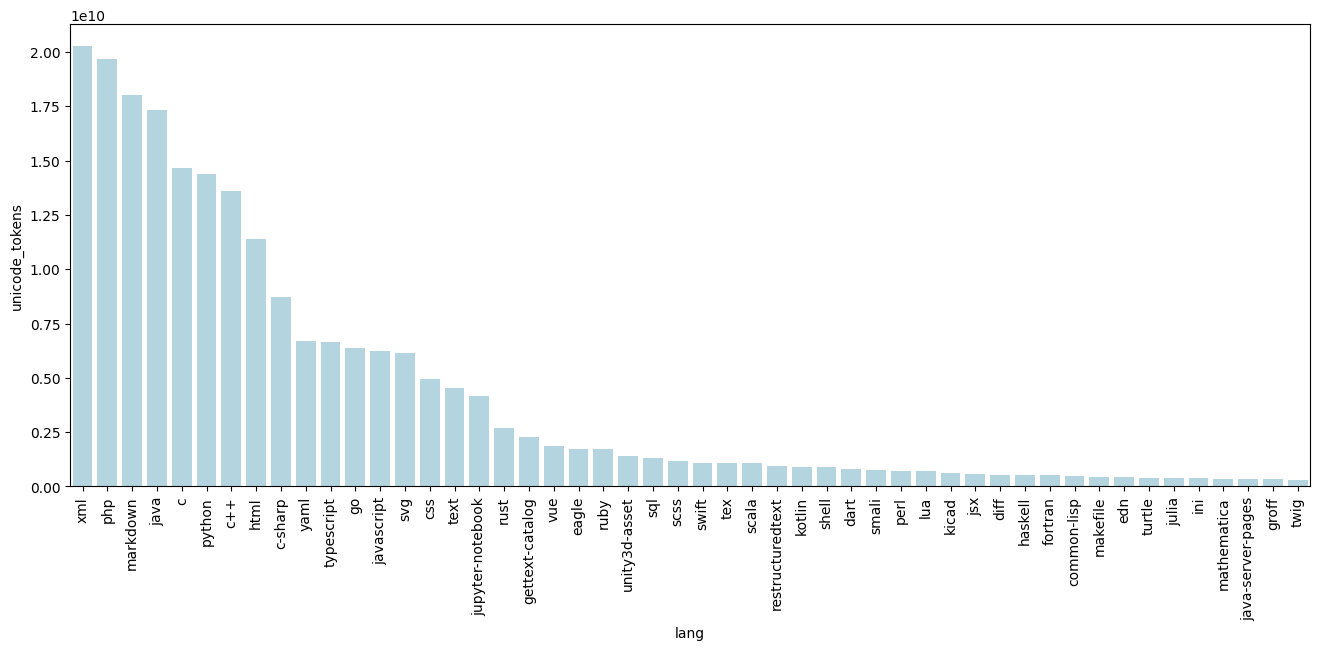

In [88]:
plt.figure(figsize=(16, 6))

ax = sns.barplot(data=dft, x="lang", y="unicode_tokens", order=dft.sort_values("unicode_tokens", ascending=False).iloc[:50].lang, color="lightblue")
ax.tick_params(axis='x', rotation=90)

In [78]:
dft.sort_values("unicode_tokens", ascending=False)

,lang,unicode_tokens
86,xml,2.024952e+10
47,php,1.965786e+10
63,markdown,1.801301e+10
220,java,1.733552e+10
76,c,1.467221e+10
...,...,...
131,python-traceback,8.256000e+03
127,nginx,4.510000e+03
22,shellsession,3.836000e+03
204,numpy,2.373000e+03


In [52]:
dft[dft["unicode_tokens"]==dft["unicode_tokens"].max()]

,unicode_tokens
xml,2.024952e+10


In [54]:
print_tokens(dft["unicode_tokens"].max())

20,249,515,182.0


In [89]:
print_tokens(200000000000)

200,000,000,000


In [90]:
dft

,lang,unicode_tokens
0,hlsl,16941728.0
1,mirah,24300583.0
2,jade,31791461.0
3,objdump,10977660.0
4,metal,3388632.0
...,...,...
346,qmake,3407802.0
347,zephir,2433674.0
348,groovy-server-pages,13086971.0
349,freemarker,66661111.0


In [91]:
total_tokens_w = 0
import glob
import pandas as pd
import tqdm

path = "../../v2/merged/*.tsv"
lang_tokens_w = {}

paths = glob.glob(path)
with tqdm.tqdm(total=len(paths)) as pbar:
    for p in paths:
        df = pd.read_csv(p, sep="\t")
        #all_dfs.append(df)
        pbar.set_description(p)
        #all_dfs.append(df["num_tokens_whitespace"])
        total_tokens_w += df["num_tokens_whitespace"].sum()
        lang = p.split("_")[1]
        lang_tokens_w[lang] = df["num_tokens_whitespace"].sum()
        pbar.update(1)

../../v2/merged/merged_isabelle_stats.tsv: 100%|██████████████████████████████████████████████████████████████████████████| 351/351 [02:51<00:00,  2.05it/s]


In [93]:
total_tokens_w

101423114874.0

### 9 May 2023

In [3]:
import pandas as pd
import os
S3_location = "s3://ai2-llm/pretraining-data/sources/stack-dedup"

In [6]:
path = os.path.join(S3_location, "v1", "documents", "python", "data_0000.jsonl.gz")
v1_ddf = pd.read_json(path, lines=True, compression="gzip")

path = os.path.join(S3_location, "v1", "attributes", "python", "data_0000.tsv")
v1_adf = pd.read_csv(path, sep="\t")

In [25]:
def curr_filter(instance_attributes):
    if instance_attributes["max_line_length"] > 1000:
        return False

    if instance_attributes["avg_line_length"] > 100:
        return False

    if instance_attributes["alnum_prop"] < 0.25:
        return False

    if instance_attributes["num_tokens_whitespace"] < 50:
        return False

    if instance_attributes["alpha_count"] / instance_attributes["num_tokens_whitespace"] < 1.5:
        return False

    return True

In [32]:
def new_filter(instance_attributes):
    if instance_attributes["max_line_length"] > 1000:
        return False

    if instance_attributes["avg_line_length"] > 100:
        return False

    if instance_attributes["alnum_prop"] < 0.25:
        return False

#     if instance_attributes["num_tokens_unicode"] < 50:
#         return False

    if instance_attributes["alpha_count"] / (instance_attributes["num_tokens_unicode"] + 0.001) < 1.5:
        return False

    return True

In [27]:
v1_adf

,id,line_count,max_line_length,num_tokens_whitespace,avg_line_length,alnum_count,alpha_count,alnum_prop,num_characters,num_tokens_unicode
0,900000adc880b3f11205aecc535df29d629a6d0c,108.0,135.0,275.0,29.861111,1845.0,1759.0,0.572093,3225.0,720
1,90000123c3c98721346f41595fd534d124b2f830,29.0,69.0,54.0,21.275862,343.0,333.0,0.555916,617.0,203
2,9000014700819c031686be68800c6f771efb2695,787.0,124.0,2175.0,41.670902,18087.0,17876.0,0.551517,32795.0,5655
3,90000324dfde4b624d3ad0979d89a438d0443b5c,112.0,119.0,411.0,49.500000,3433.0,3364.0,0.619228,5544.0,1007
4,9000053b61a61a1ac2159e9bc1406f2b350532b6,32.0,39.0,74.0,22.031250,319.0,299.0,0.452482,705.0,175
...,...,...,...,...,...,...,...,...,...,...
152097,d5a39bddc227e2320abd0ac10ad3a6e499a3455a,9.0,62.0,18.0,24.555556,165.0,165.0,0.746606,221.0,25
152098,d5a39d463bd373321c5c571d263bbda7325d4811,49.0,81.0,146.0,28.020408,1011.0,1009.0,0.736344,1373.0,254
152099,d5a39e6052dec6a6ade93459410a765d7d0c49c9,188.0,91.0,465.0,33.595745,3545.0,3534.0,0.561273,6316.0,875
152100,d5a39eb2f736ab4cd0cd0395f70d0a284bb8c52f,95.0,84.0,225.0,38.800000,2043.0,2016.0,0.554259,3686.0,564


In [28]:
curr = v1_adf[v1_adf.apply(curr_filter, axis=1)]

In [33]:
newf = v1_adf[v1_adf.apply(new_filter, axis=1)]

In [34]:
len(curr)

118275

In [35]:
len(newf)

144685

In [36]:
import pandas as pd

In [37]:
path = os.path.join(S3_location, "v1", "attributes", "python", "data_0000.tsv")
v1_adf = pd.read_csv(path, sep="\t")

In [38]:
v1_adf

,id,line_count,max_line_length,num_tokens_whitespace,avg_line_length,alnum_count,alpha_count,alnum_prop,num_characters,num_tokens_unicode
0,900000adc880b3f11205aecc535df29d629a6d0c,108.0,135.0,275.0,29.861111,1845.0,1759.0,0.572093,3225.0,720
1,90000123c3c98721346f41595fd534d124b2f830,29.0,69.0,54.0,21.275862,343.0,333.0,0.555916,617.0,203
2,9000014700819c031686be68800c6f771efb2695,787.0,124.0,2175.0,41.670902,18087.0,17876.0,0.551517,32795.0,5655
3,90000324dfde4b624d3ad0979d89a438d0443b5c,112.0,119.0,411.0,49.500000,3433.0,3364.0,0.619228,5544.0,1007
4,9000053b61a61a1ac2159e9bc1406f2b350532b6,32.0,39.0,74.0,22.031250,319.0,299.0,0.452482,705.0,175
...,...,...,...,...,...,...,...,...,...,...
152097,d5a39bddc227e2320abd0ac10ad3a6e499a3455a,9.0,62.0,18.0,24.555556,165.0,165.0,0.746606,221.0,25
152098,d5a39d463bd373321c5c571d263bbda7325d4811,49.0,81.0,146.0,28.020408,1011.0,1009.0,0.736344,1373.0,254
152099,d5a39e6052dec6a6ade93459410a765d7d0c49c9,188.0,91.0,465.0,33.595745,3545.0,3534.0,0.561273,6316.0,875
152100,d5a39eb2f736ab4cd0cd0395f70d0a284bb8c52f,95.0,84.0,225.0,38.800000,2043.0,2016.0,0.554259,3686.0,564


In [40]:
m = pd.merge(v1_ddf, v1_adf, on="id")

In [42]:
m[v1_ddf.columns]

,id,lang,text,metadata,timestamp,source,added
0,900000adc880b3f11205aecc535df29d629a6d0c,python,"""""""\nbenchmarking et plotting some results for...","{'size': 3225, 'ext': 'py', 'max_stars_repo_pa...",2022-12-01,stack-dedup,2023-03-17T09:18:30.577245
1,90000123c3c98721346f41595fd534d124b2f830,python,temp =[]\nprinc=[]\nmaior=menor=0\n\nwhile Tru...,"{'size': 617, 'ext': 'py', 'max_stars_repo_pat...",2022-12-01,stack-dedup,2023-03-17T09:18:30.577245
2,9000014700819c031686be68800c6f771efb2695,python,"""""""\nThis module implements an API for interac...","{'size': 32795, 'ext': 'py', 'max_stars_repo_p...",2022-12-01,stack-dedup,2023-03-17T09:18:30.577245
3,90000324dfde4b624d3ad0979d89a438d0443b5c,python,from ._object_env import ObjectEnv\nfrom ._obj...,"{'size': 5544, 'ext': 'py', 'max_stars_repo_pa...",2022-12-01,stack-dedup,2023-03-17T09:18:30.577245
4,9000053b61a61a1ac2159e9bc1406f2b350532b6,python,from benchmark import Benchmark\n\n\nclass Per...,"{'size': 1857, 'ext': 'py', 'max_stars_repo_pa...",2022-12-01,stack-dedup,2023-03-17T09:18:30.577245
...,...,...,...,...,...,...,...
152097,d5a39bddc227e2320abd0ac10ad3a6e499a3455a,python,from rest_framework import serializers\nfrom a...,"{'size': 221, 'ext': 'py', 'max_stars_repo_pat...",2022-12-01,stack-dedup,2023-03-17T09:18:30.577245
152098,d5a39d463bd373321c5c571d263bbda7325d4811,python,"__author__ = ""Simone Campagna""\n\n__all__ = [\...","{'size': 1980, 'ext': 'py', 'max_stars_repo_pa...",2022-12-01,stack-dedup,2023-03-17T09:18:30.577245
152099,d5a39e6052dec6a6ade93459410a765d7d0c49c9,python,import logging\nfrom contextlib import closing...,"{'size': 6355, 'ext': 'py', 'max_stars_repo_pa...",2022-12-01,stack-dedup,2023-03-17T09:18:30.577245
152100,d5a39eb2f736ab4cd0cd0395f70d0a284bb8c52f,python,from django.core.management.base import BaseCo...,"{'size': 3686, 'ext': 'py', 'max_stars_repo_pa...",2022-12-01,stack-dedup,2023-03-17T09:18:30.577245


In [46]:


from detect_secrets import SecretsCollection
from detect_secrets.settings import default_settings
from detect_secrets.core.scan import PotentialSecret, get_plugins, _process_line_based_plugins
from typing import Generator

the_str = "code_str.yml"

def scan_code(code: str) -> Generator[PotentialSecret, None, None]:
    if not get_plugins():   # pragma: no cover
        log.error('No plugins to scan with!')
        return

    has_secret = False
    for lines in [code.splitlines()]:
        for secret in _process_line_based_plugins(
            lines=list(enumerate(lines, start=1)),
            filename=the_str,
        ):
            has_secret = True
            yield secret

        if has_secret:
            break

class MySecretsCollection(SecretsCollection):
    def scan_str(self, code_str: str):
        for secret in scan_code(code_str):
            self[the_str].add(secret)

def check_for_secrets(code: str):
    secrets = MySecretsCollection()
    with default_settings():
        secrets.scan_str(code)

    secrets_json = secrets.json()
    return secrets_json
#     if secrets_json:
# #         for secret in secrets_json[the_str]:
# #             print("verified", secret["is_verified"])
#         return True
#     return False

In [55]:
s = """
\"\"\"
Django settings for mysite project.

Generated by 'django-admin startproject' using Django 3.2.

For more information on this file, see
https://docs.djangoproject.com/en/3.2/topics/settings/

For the full list of settings and their values, see
https://docs.djangoproject.com/en/3.2/ref/settings/
\"\"\"

from pathlib import Path

# Build paths inside the project like this: BASE_DIR / 'subdir'.
BASE_DIR = Path(__file__).resolve().parent.parent


# Quick-start development settings - unsuitable for production
# See https://docs.djangoproject.com/en/3.2/howto/deployment/checklist/

# SECURITY WARNING: keep the secret key used in production secret!
SECRET_KEY = 'django-insecure-$su^!=k#jx24b_mg1(oi)j7vgio%9gtbb+)uv1mw420r#mp%ru'

hello = "T2w5Vl9ZTUIzVzE5dTlBblUtRlo6MHNBYWxhbHVTeGFodUpUOWIybkNNZw=="

# SECURITY WARNING: don't run with debug turned on in production!
DEBUG = True

ALLOWED_HOSTS = []


# Application definition

INSTALLED_APPS = [
    'django.contrib.admin',
    'django.contrib.auth',
    'django.contrib.contenttypes',
    'django.contrib.sessions',
    'django.contrib.messages',
    'django.contrib.staticfiles',
    
    
    'game.apps.GameConfig',
]

MIDDLEWARE = [
    'django.middleware.security.SecurityMiddleware',
    'django.contrib.sessions.middleware.SessionMiddleware',
    'django.middleware.common.CommonMiddleware',
    'django.middleware.csrf.CsrfViewMiddleware',
    'django.contrib.auth.middleware.AuthenticationMiddleware',
    'django.contrib.messages.middleware.MessageMiddleware',
    'django.middleware.clickjacking.XFrameOptionsMiddleware',
]

ROOT_URLCONF = 'mysite.urls'

TEMPLATES = [
    {
        'BACKEND': 'django.template.backends.django.DjangoTemplates',
        'DIRS': [BASE_DIR / 'templates'],
        'APP_DIRS': True,
        'OPTIONS': {
            'context_processors': [
                'django.template.context_processors.debug',
                'django.template.context_processors.request',
                'django.contrib.auth.context_processors.auth',
                'django.contrib.messages.context_processors.messages',
            ],
        },
    },
]

WSGI_APPLICATION = 'mysite.wsgi.application'


# Database
# https://docs.djangoproject.com/en/3.2/ref/settings/#databases

DATABASES = {
    'default': {
        'ENGINE': 'django.db.backends.sqlite3',
        'NAME': BASE_DIR / 'db.sqlite3',
    }
}


# Password validation
# https://docs.djangoproject.com/en/3.2/ref/settings/#auth-password-validators

AUTH_PASSWORD_VALIDATORS = [
    {
        'NAME': 'django.contrib.auth.password_validation.UserAttributeSimilarityValidator',
    },
    {
        'NAME': 'django.contrib.auth.password_validation.MinimumLengthValidator',
    },
    {
        'NAME': 'django.contrib.auth.password_validation.CommonPasswordValidator',
    },
    {
        'NAME': 'django.contrib.auth.password_validation.NumericPasswordValidator',
    },
]


# Internationalization
# https://docs.djangoproject.com/en/3.2/topics/i18n/

LANGUAGE_CODE = 'fa-ir'

TIME_ZONE = 'Asia/Tehran'

USE_I18N = True

USE_L10N = True

USE_TZ = True


# Static files (CSS, JavaScript, Images)
# https://docs.djangoproject.com/en/3.2/howto/static-files/

STATIC_URL = '/static/'

# Default primary key field type
# https://docs.djangoproject.com/en/3.2/ref/settings/#default-auto-field

DEFAULT_AUTO_FIELD = 'django.db.models.BigAutoField'
"""

In [56]:
check_for_secrets('hello = "T2w5Vl9ZTUIzVzE5dTlBblUtRlo6MHNBYWxhbHVTeGFodUpUOWIybkNNZw=="\n some code \nhi = "T2w5Vl9ZTUIzVzE5dTlBblUtRlo6MHNBYWxhbHVTeGFodUpUOWIybkNNZw==""')

{'code_str.yml': [{'type': 'Base64 High Entropy String',
   'filename': 'code_str.yml',
   'hashed_secret': '77bc6e77f90bb4cf444e33c444cf8cd07c0c0490',
   'is_verified': False,
   'line_number': 1}]}

In [65]:
secrets = check_for_secrets(s)

In [50]:
!detect-secrets scan --list-all-plugins

ArtifactoryDetector
AWSKeyDetector
AzureStorageKeyDetector
BasicAuthDetector
CloudantDetector
DiscordBotTokenDetector
GitHubTokenDetector
Base64HighEntropyString
HexHighEntropyString
IbmCloudIamDetector
IbmCosHmacDetector
JwtTokenDetector
KeywordDetector
MailchimpDetector
NpmDetector
PrivateKeyDetector
SendGridDetector
SlackDetector
SoftlayerDetector
SquareOAuthDetector
StripeDetector
TwilioKeyDetector


In [63]:
secret = s.splitlines()[23]
start = s.find(s.splitlines()[23])
end = start + len(secret)

In [64]:
s[start:end]

"SECRET_KEY = 'django-insecure-$su^!=k#jx24b_mg1(oi)j7vgio%9gtbb+)uv1mw420r#mp%ru'"

In [69]:
secrets["code_str.yml"]

[{'type': 'Secret Keyword',
  'filename': 'code_str.yml',
  'hashed_secret': '573c14ff8674c1ad6031b4e403a28847cafa2881',
  'is_verified': False,
  'line_number': 24},
 {'type': 'Base64 High Entropy String',
  'filename': 'code_str.yml',
  'hashed_secret': '77bc6e77f90bb4cf444e33c444cf8cd07c0c0490',
  'is_verified': False,
  'line_number': 26}]

In [72]:
total_tokens = 0
import glob
import pandas as pd
import tqdm

path = "../../v3_merged/*.tsv"
lang_tokens = {}

paths = glob.glob(path)
with tqdm.tqdm(total=len(paths)) as pbar:
    for p in paths:
        df = pd.read_csv(p, sep="\t")
        #all_dfs.append(df)
        pbar.set_description(p)
        #all_dfs.append(df["num_tokens_whitespace"])
        total_tokens += df["num_tokens_unicode"].sum()
        lang = p.split("_")[1]
        lang_tokens[lang] = df["num_tokens_unicode"].sum()
        pbar.update(1)

../../v3_merged/merged_isabelle_stats.tsv: 100%|██████████████████████████████████████████████████████████████████████████| 350/350 [03:27<00:00,  1.68it/s]


In [73]:
total_tokens

212946057447.0

In [75]:
print_tokens(total_tokens)

212,946,057,447.0


In [76]:
total_tokens = 0
import glob
import pandas as pd
import tqdm

path = "../../v2_merged/*.tsv"
lang_tokens = {}

paths = glob.glob(path)
with tqdm.tqdm(total=len(paths)) as pbar:
    for p in paths:
        df = pd.read_csv(p, sep="\t")
        #all_dfs.append(df)
        pbar.set_description(p)
        #all_dfs.append(df["num_tokens_whitespace"])
        total_tokens += df["num_tokens_unicode"].sum()
        lang = p.split("_")[1]
        lang_tokens[lang] = df["num_tokens_unicode"].sum()
        pbar.update(1)

../../v2_merged/merged_isabelle_stats.tsv: 100%|██████████████████████████████████████████████████████████████████████████| 350/350 [02:52<00:00,  2.03it/s]


In [79]:
print_tokens(total_tokens)

217,376,536,914.0
